# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython

# 2. Importing and visualizing data

### 2.1 Original features

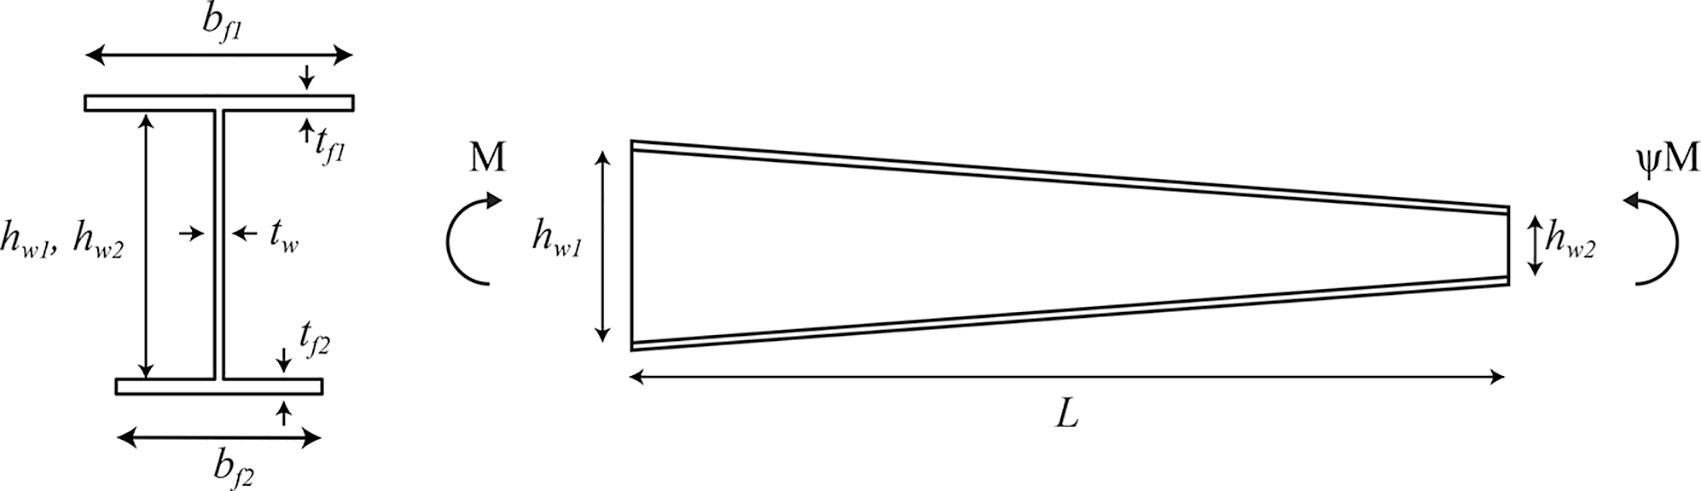

In [2]:
IPython.display.Image("1-s2.0-S2352012422004581-gr4_lrg.jpg")

In [3]:
df = pd.read_csv("training_set.csv", sep=';')
df_y_normalized = pd.read_csv("training_set_normalized.csv", sep = ";")
df["y_norm"] = df_y_normalized.y.copy()
display(df)

hw1  hw2    tw  bf1    tf1  bf2    tf2   psi      L             y  \
0       500  167  2.09  500  17.89  375  13.42 -0.75  19000   1703.681777   
1       700  280  4.75  525  34.26  700  40.53 -0.75  28000   6745.446061   
2       400  400  1.67  100   6.89  300  18.47  0.75   8000    143.526934   
3       160  400  3.43  200   9.37  100   6.89 -0.25   7200    145.486862   
4       100  400  1.33  300  15.16  300   4.11  1.00   5600    643.674997   
...     ...  ...   ...  ...    ...  ...    ...   ...    ...           ...   
60544  1000  400  8.57  750  24.08  250   8.57  0.00  12000  15166.541030   
60545   900  900  6.11  225  17.17  675  34.11  1.00  18000    955.055842   
60546   400  100  1.67  300  18.47  100   7.26 -0.50   8000   1445.528301   
60547   200  600  6.97  450  34.34  150   9.24  0.50   8400   4352.341060   
60548   143  500  2.40  500  19.74  125   4.93  1.00  11000   1055.219838   

          y_norm  
0       4.270872  
1       2.496103  
2       0.919286  
3       3.724770  
4       1.521069  
...          ...  
60544   7.885136  
60545   0.625638  
60546  10.890812  
60547   4.736697  
60548   4.122505  

[60549 rows x 11 columns]

In [4]:
df.info()
# All the variables are floats or integers.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60549 entries, 0 to 60548
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hw1     60549 non-null  int64  
 1   hw2     60549 non-null  int64  
 2   tw      60549 non-null  float64
 3   bf1     60549 non-null  int64  
 4   tf1     60549 non-null  float64
 5   bf2     60549 non-null  int64  
 6   tf2     60549 non-null  float64
 7   psi     60549 non-null  float64
 8   L       60549 non-null  int64  
 9   y       60549 non-null  float64
 10  y_norm  60549 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 5.1 MB


In [5]:
df.isnull().sum()
# there are no NaN values

hw1       0
hw2       0
tw        0
bf1       0
tf1       0
bf2       0
tf2       0
psi       0
L         0
y         0
y_norm    0
dtype: int64

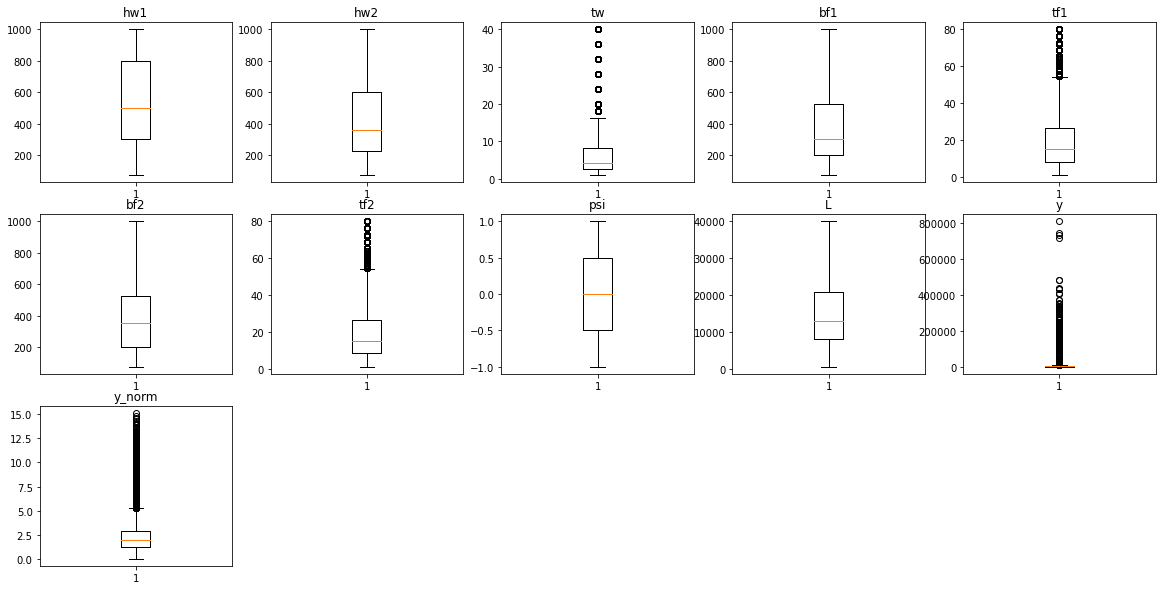

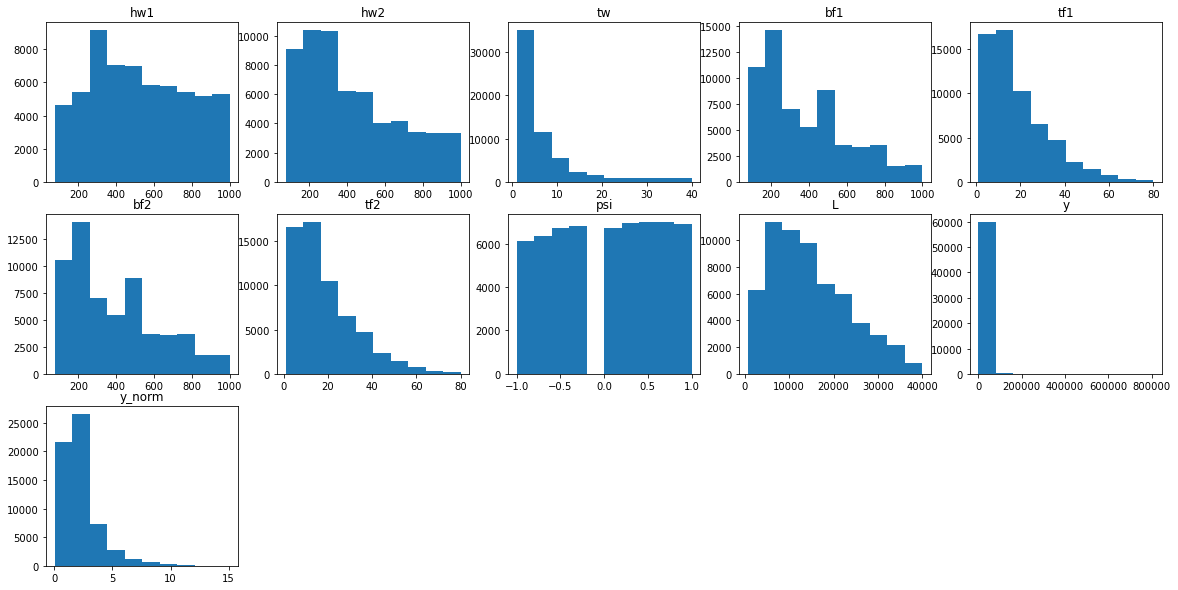

In [6]:
# Boxplots
plt.figure(figsize=(20,10))
for i in range(len(df.columns)):
    plt.subplot(3,5,i+1)
    plt.boxplot(df.iloc[:,i])
    plt.title(df.columns[i])

# Histograms
plt.figure(figsize=(20,10))
for i in range(len(df.columns)):
    plt.subplot(3,5,i+1)
    plt.hist(df.iloc[:,i])
    plt.title(df.columns[i])

# 3. Feature engineering

### 3.1 Eliminating samples with outliers in target variable

In [7]:
def df_outlier_elimination(df, target = "norm"):
    
    if target == "norm":
        y = df.copy().y_norm.values
    elif target == "original":
        y = df.copy().y.values
    else:
        print("error: type 'norm' or 'original', other input for <<target>> is not valid!")
    y_sort = np.sort(y)
    # quantiles
    Q1 = y_sort[round(len(y_sort)*0.25)]
    Q3 = y_sort[round(len(y_sort)*0.75)]
    # indices of outliers
    lower_indices = [i for i in range(len(y)) if y[i] < Q1-1.5*(Q3-Q1)]
    upper_indices = [i for i in range(len(y)) if y[i] > Q3+1.5*(Q3-Q1)]
    
    return df.copy().drop(index = lower_indices + upper_indices)

### 3.2 Generated features

- Taper ratio: $h_{w, max}/h_{w, min}$
- Flange width ratio: $b_{f1}/b_{f2}$
- Height to width ratio: $h_{w, max}/b_{f, max}$
- Beam length: $L/h_{w, max}$
- Plate thickness ratio: $t_{f1}/t_{w}; t_{f2}/t_{w}$
- Flange slenderness: $b_{f1}/t_{f1}; b_{f2}/t_{fs}$
- Web slenderness: $h_{w, max}/t_{w}$;

In [8]:
def df_extend(df):
    """
    this function creates new variables useful for the model
    these new variables are explained in the original paper
    """
    df_extended = df.copy()

    # creating new features
    df_extended["taper_ratio"] = df_extended[["hw1","hw2"]].max(axis=1) / df_extended[["hw1","hw2"]].min(axis=1)
    df_extended["flange_width_ratio"] = df_extended.bf1 / df_extended.bf2
    df_extended["height_to_width_ratio"] = df_extended[["hw1","hw2"]].max(axis=1) / df_extended[["bf1","bf2"]].max(axis=1)
    df_extended["beam_length"] = df_extended.L / df_extended[["hw1","hw2"]].max(axis=1)
    df_extended["plate_thickness_ratio_1"] = df_extended.tf1 / df_extended.tw
    df_extended["plate_thickness_ratio_2"] = df_extended.tf2 / df_extended.tw
    df_extended["flange_slenderness_1"] = df_extended.bf1 / df_extended.tf1
    df_extended["flange_slenderness_2"] = df_extended.bf2 / df_extended.tf2
    df_extended["web_slenderness"] = df_extended[["hw1", "hw2"]].max(axis=1) / df_extended.tw

    # change y and y_norm positions
    y_aux = df_extended.y
    y_norm_aux = df_extended.y_norm
    df_extended = df_extended.drop(columns=["y", "y_norm"])
    df_extended["y"] = y_aux
    df_extended["y_norm"] = y_norm_aux

    return df_extended

### 3.3 Plotting data with new features and filtered target

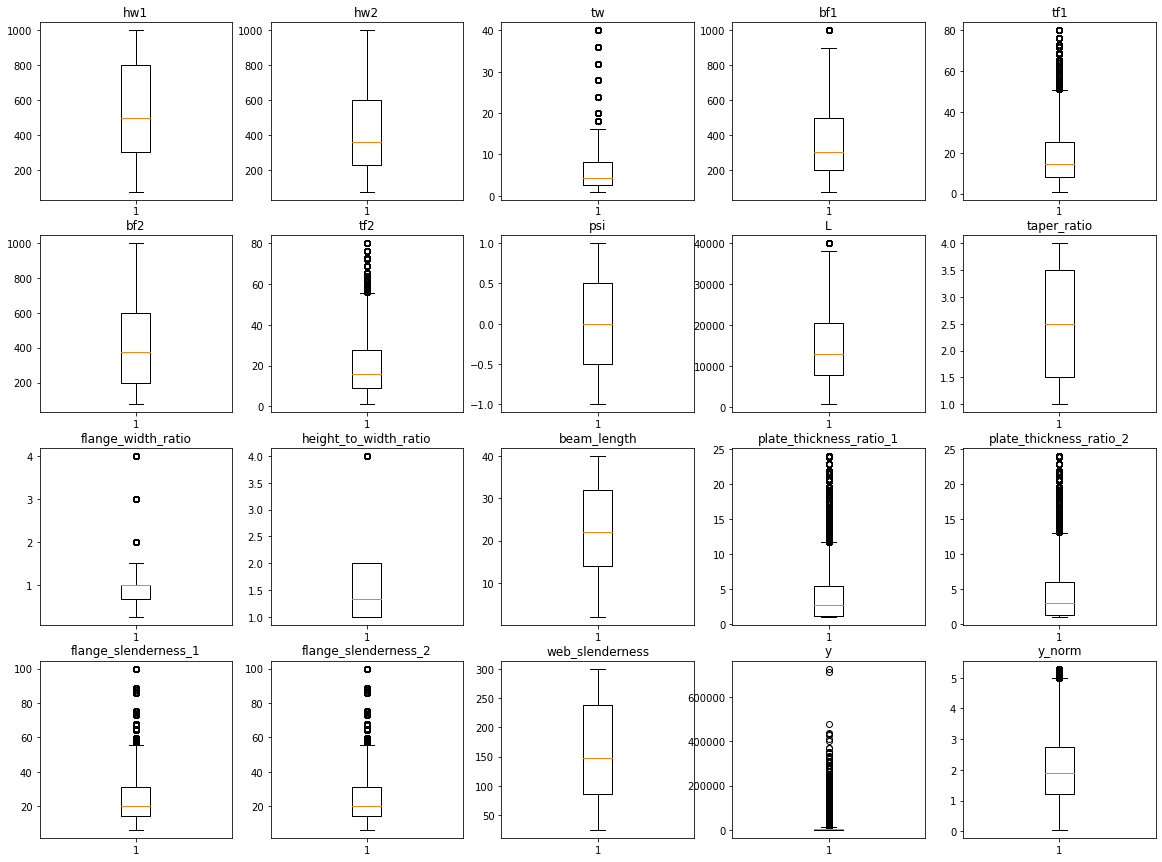

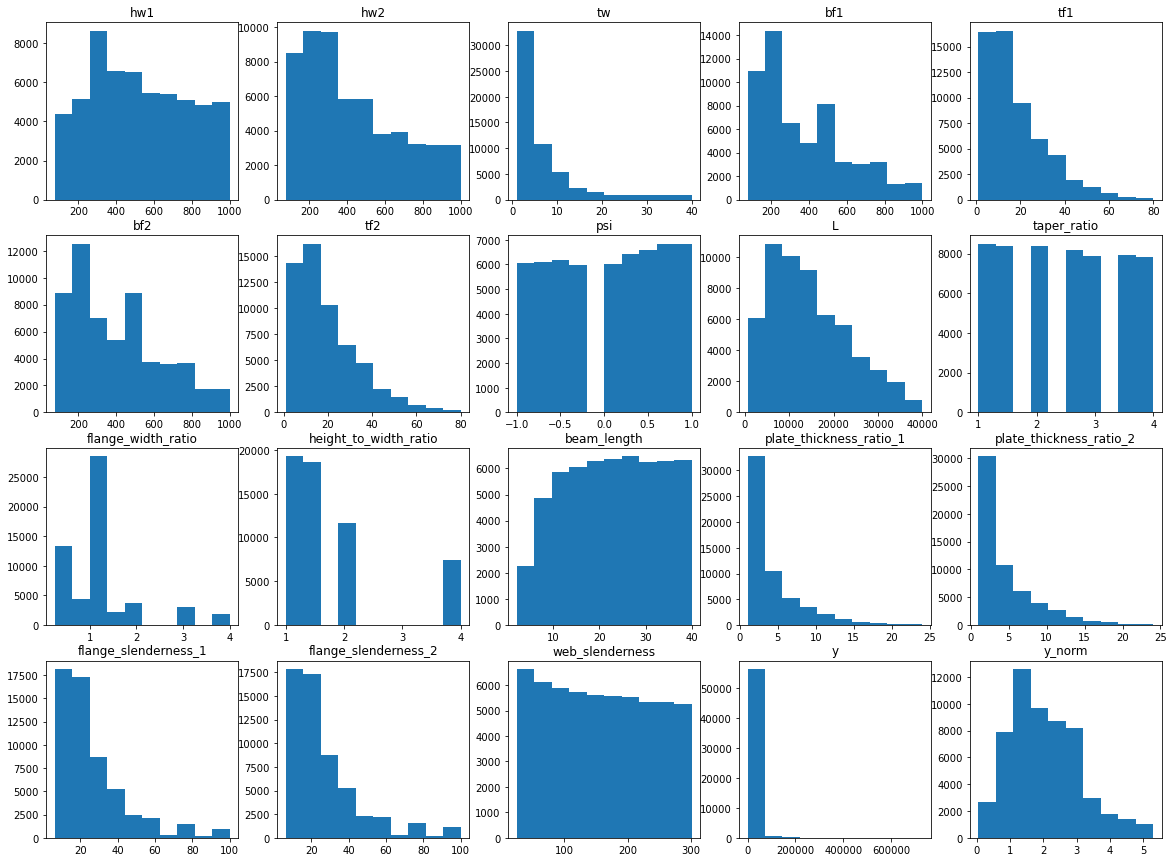

In [9]:
df_new = df_outlier_elimination(df_extend(df.copy()), target="norm")
%matplotlib inline
# Boxplots
plt.figure(figsize=(20,15))
for i in range(len(df_new.columns)):
    plt.subplot(4,5,i+1)
    plt.boxplot(df_new.iloc[:,i])
    plt.title(df_new.columns[i])

# Histograms
plt.figure(figsize=(20,15))
for i in range(len(df_new.columns)):
    plt.subplot(4,5,i+1)
    plt.hist(df_new.iloc[:,i])
    plt.title(df_new.columns[i])

### 3.4 Feature selection

Feature selection resorting to Lasso regression

In [10]:
def l1_feature_score(X, y):
    
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler

    # scaling X
    X = StandardScaler().fit_transform(X)
    # potential alpha values
    parameters = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]}
    # grid search for best alpha
    clf = GridSearchCV(Lasso(), parameters)
    clf = clf.fit(X, y)
    alpha = clf.best_params_["alpha"]
    # feature scoring
    lasso = Lasso(alpha = alpha)
    lasso.fit(X, y)
    feature_score = lasso.coef_

    return feature_score

##### 3.4.1 Feature ranking 

Feature scoring through Lasso regression and L1 penalty

In [11]:
dataframe1 = df_extend(df.copy()) # with outliers
dataframe2 = df_outlier_elimination(df_extend(df.copy()), target='original')
dataframe3 = df_outlier_elimination(df_extend(df.copy()), target='norm')

# feature ranking with non-normalized y (with outliers)
features_score1 = l1_feature_score(dataframe1.iloc[:, :-2].values, dataframe1.y.values)

# feature ranking with non-normalized y (without outliers)
features_score2 = l1_feature_score(dataframe2.iloc[:, :-2].values, dataframe2.y.values)

# feature ranking with normalized y (with outliers)
features_score3 = l1_feature_score(dataframe1.iloc[:, :-2].values, dataframe1.y_norm.values)

# feature ranking with normalized y (without outliers)
features_score4 = l1_feature_score(dataframe3.iloc[:, :-2].values, dataframe3.y_norm.values)

Plotting the relative feature importance

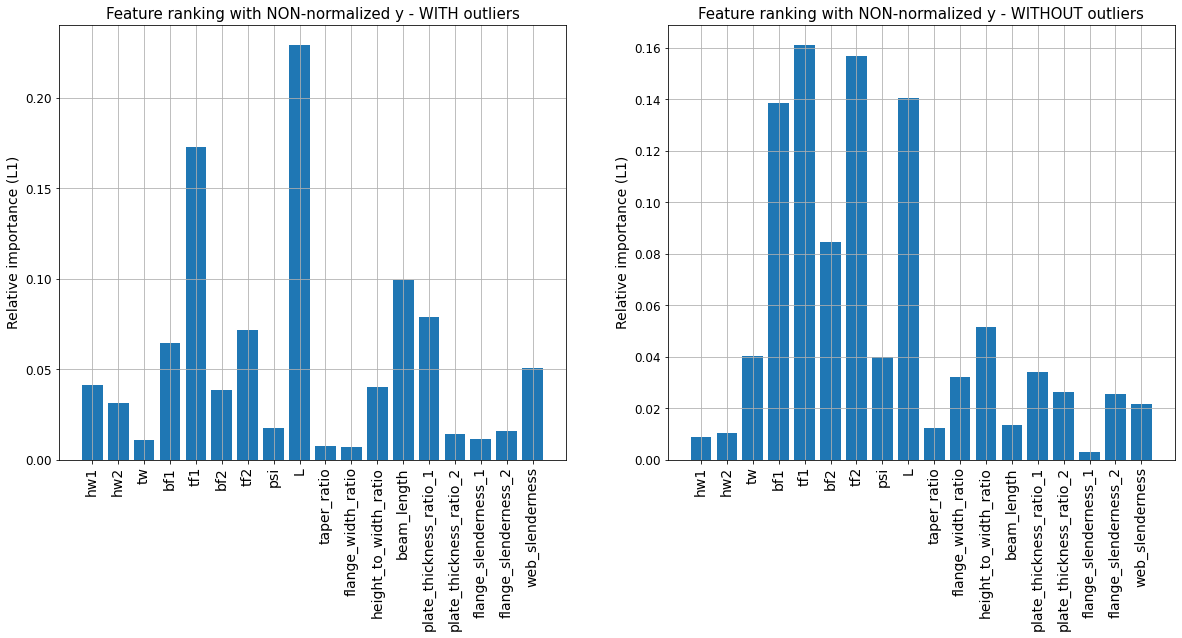

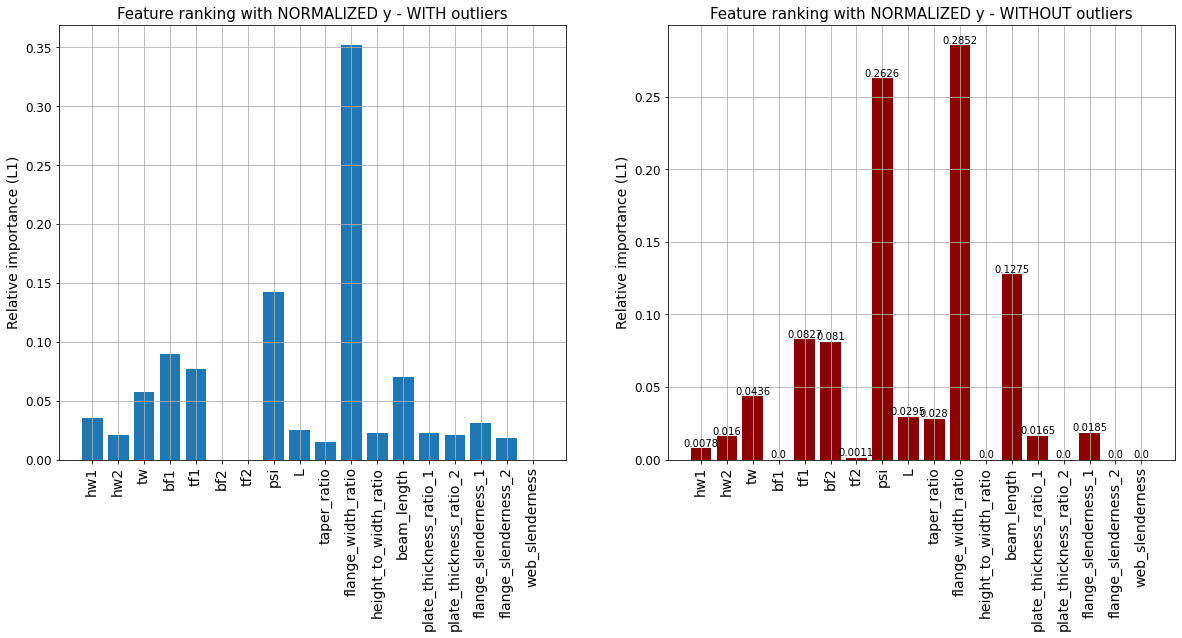

In [12]:
plt.figure(figsize=(20, 8))

# feature ranking with non-normalized y (with outliers)
plt.subplot(1, 2, 1)
plt.bar(x = dataframe1.columns[:-2], height = np.abs(features_score1)/np.sum(np.abs(features_score1)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NON-normalized y - WITH outliers", fontsize=15)
plt.grid()

# feature ranking with non-normalized y (without outliers)
plt.subplot(1, 2, 2)
plt.bar(x = dataframe2.columns[:-2], height = np.abs(features_score2)/np.sum(np.abs(features_score2)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NON-normalized y - WITHOUT outliers", fontsize=15)
plt.grid()

plt.show()

plt.figure(figsize=(20, 8))

# feature ranking with normalized y (with outliers)
plt.subplot(1, 2, 1)
plt.bar(x = dataframe1.columns[:-2], height = np.abs(features_score3)/np.sum(np.abs(features_score3)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NORMALIZED y - WITH outliers", fontsize=15)
plt.grid()

# feature ranking with normalized y (without outliers)
plt.subplot(1, 2, 2)
bars = plt.bar(x = dataframe3.columns[:-2], height = np.abs(features_score4)/np.sum(np.abs(features_score4)), color="darkred")
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NORMALIZED y - WITHOUT outliers", fontsize=15)
plt.grid()

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            round(bar.get_height(), 4), 
            ha='center', va='bottom')

plt.show()


# 4. Automized version with sklearn

In [27]:
def modelAuto(df_train, df_test, PolyDegree, select_thresh = 0, alpha = 0.0001, cv = False):

    import numpy as np
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    
    # eliminating target outliers and creating compound features
    train = df_extend(df_train.copy())
    train = df_outlier_elimination(train, target="norm")

    # arrays for training
    X_train = train.iloc[:, :-2].values
    y_train = train.y_norm.values

    # L1 feature selection
    FeatureScore = l1_feature_score(X_train, y_train)
    FeatureScore = np.abs(FeatureScore) / np.sum(np.abs(FeatureScore)) # relative importance
    FeatureIndex = np.argwhere(FeatureScore >= select_thresh)
    FeatureIndex = FeatureIndex.reshape((1, len(FeatureIndex)))
    print("Selected features:")
    print(list(train.columns[FeatureIndex[0]]))
    X_train_filt = X_train[:, FeatureIndex[0]]
        
    # polynomial features
    poly = PolynomialFeatures(degree = PolyDegree).fit(X_train_filt)
    X_train_poly = poly.transform(X_train_filt)

    # normalization
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_poly)

    # regression
    if PolyDegree <= 4:
        regressor = LinearRegression()
    else:
        if cv == True:
            # alpha determined through grid search
            parameters = {"alpha": [0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}
            grid_search = GridSearchCV(Lasso(), parameters, cv=5)
            grid_search.fit(X_train_norm, y_train)
            alpha = grid_search.best_params_["alpha"]
            regressor = Lasso(alpha = alpha)
        else:
            # given alpha
            regressor = Lasso(alpha = alpha)
    regressor.fit(X_train_norm, y_train)

    # testing set
    test = df_extend(df_test.copy())

    # testing set transformations
    X_test = test.iloc[:, :-2].values
    y_test = test.y_norm.values
    X_test_filt = X_test[:, FeatureIndex[0]]
    X_test_poly = poly.transform(X_test_filt)
    X_test_norm = scaler.transform(X_test_poly)

    # predictions
    y_train_pred = regressor.predict(X_train_norm)
    y_test_pred = regressor.predict(X_test_norm)

    # mean absolute error
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print("Training MAE:", mae_train)
    print("Testing MAE:", mae_test)

    # mean absolute error
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print("Training MSE:", mse_train)
    print("Testing MSE:", mse_test)

    # coefficient of determination
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print("Training R^2:", r2_train)
    print("Testing R^2:", r2_test)

    plt.figure(figsize=(15,15))

    # Training results visualization
    plt.subplot(2, 2, 1)
    plt.scatter(y_train, y_train_pred)
    plt.plot(range(7), range(7), color="black")
    plt.xlabel("True", fontsize=12)
    plt.ylabel("Prediction", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Train", fontsize=15)
    plt.grid()

    # Testing results visualization
    plt.subplot(2, 2, 2)
    plt.scatter(y_test, y_test_pred, color="red")
    plt.plot(range(16), range(16), color="black")
    plt.xlabel("True", fontsize=12)
    plt.ylabel("Prediction", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Test", fontsize=15)
    plt.grid()

    # Training results visualization (normalized)
    plt.subplot(2, 2, 3)
    plt.scatter(MinMaxScaler().fit_transform(y_train.reshape(-1,1)), 
                MinMaxScaler().fit_transform(y_train_pred.reshape(-1,1)))
    plt.plot(range(2), range(2), color="black")
    plt.xlabel("True (normalized)", fontsize=12)
    plt.ylabel("Prediction (normalized)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Train - normalized", fontsize=15)
    plt.grid()

    # Testing results visualization (normalized)
    plt.subplot(2, 2, 4)
    plt.scatter(MinMaxScaler().fit_transform(y_test.reshape(-1,1)), 
                MinMaxScaler().fit_transform(y_test_pred.reshape(-1,1)), 
                color="red")
    plt.plot(range(2), range(2), color="black")
    plt.xlabel("True (normalized)", fontsize=12)
    plt.ylabel("Prediction (normalized)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Test - normalized", fontsize=15)
    plt.grid()

    if PolyDegree <= 4:
        plt.suptitle("Linear Regression \n polynomial degree = "+str(PolyDegree)+", score threshold = "+str(select_thresh), fontsize=20)
    else:
        plt.suptitle("Lasso Regression \n polynomial degree = "+str(PolyDegree)+", alpha = "+str(alpha), fontsize=20)
    plt.show()

    return regressor, {"mae_train": mae_train, 
                       "mae_test": mae_test, 
                       "mse_train": mse_train, 
                       "mse_test": mse_test, 
                       "r2_train": r2_train, 
                       "r2_test": r2_test}


### 4.1 Grid Search

In [14]:
# train
df_train = pd.read_csv("training_set.csv", sep=';')
df_train_normalized = pd.read_csv("training_set_normalized.csv", sep = ";")
df_train["y_norm"] = df_train_normalized.y.copy()

# test
df_test = pd.read_csv("testing_set.csv", sep=";")
df_test_normalized = pd.read_csv("testing_set_normalized.csv", sep=";")
df_test["y_norm"] = df_test_normalized.y.copy()

# lasso relative score for feature selection
thresholds = [0.0000, 0.0005, 0.0012, 0.0080, 0.0161, 0.0166, 0.0186, 0.0290, 0.0300, 0.0450]

# alpha for lasso regression with PolyDegree > 4
alpha = [0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

# dictionary to store the results
models_evalution = dict()

##### 4.1.1 Polynomial degree: 1

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.5424043043509201
Testing MAE: 0.7468118702991361
Training MSE: 0.5682657357363139
Testing MSE: 1.4983695865151503
Training R^2: 0.48336406409283095
Testing R^2: 0.4557051303520979


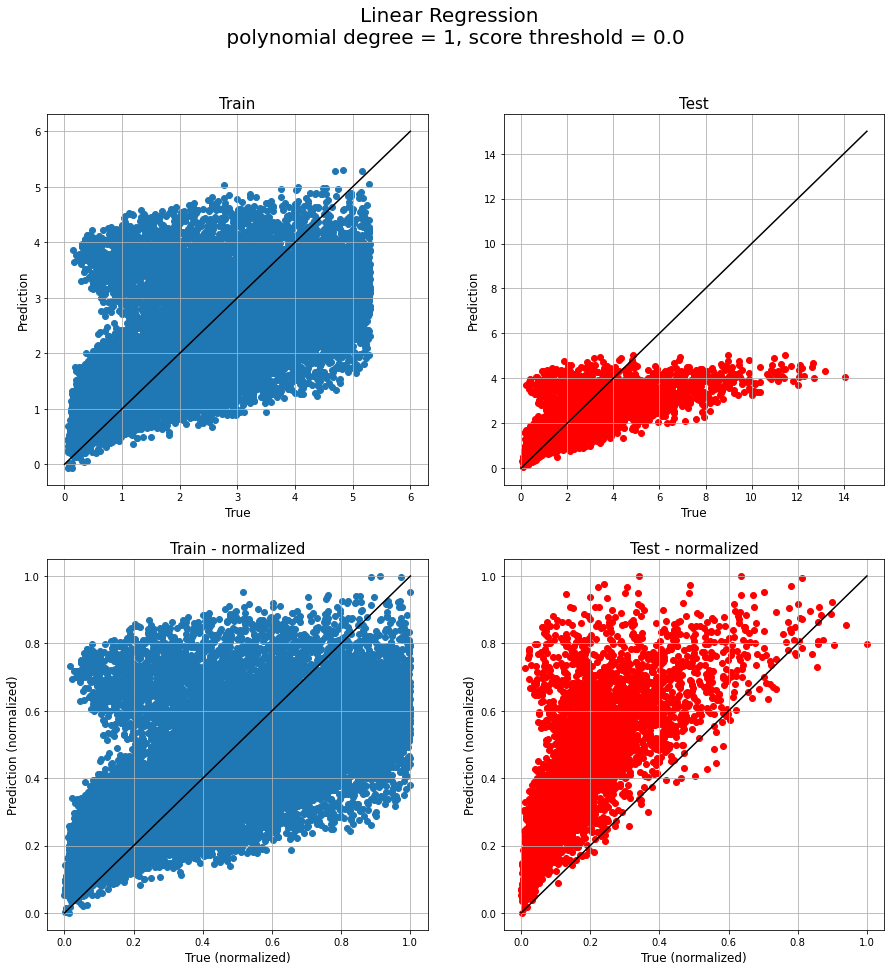


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.54321824434569
Testing MAE: 0.7512498720071493
Training MSE: 0.5705001581496202
Testing MSE: 1.517973040051435
Training R^2: 0.4813326501924051
Testing R^2: 0.44858401732150255


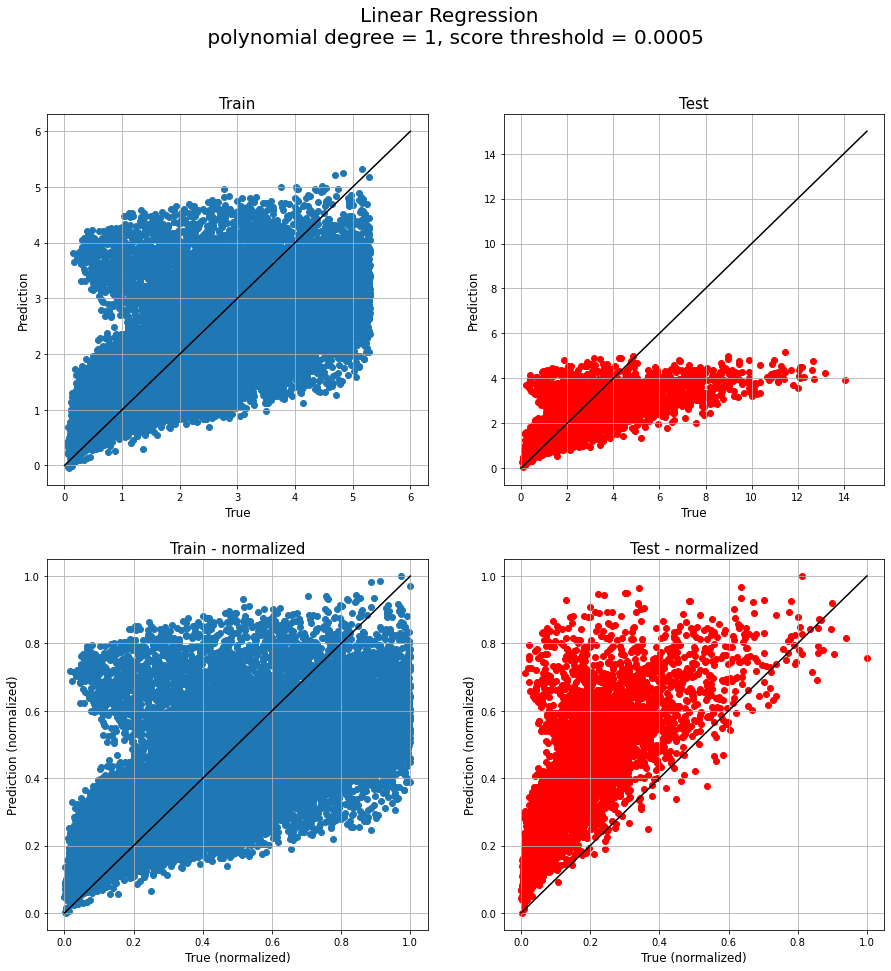


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.5427201122951631
Testing MAE: 0.7498149443239888
Training MSE: 0.5710922268332331
Testing MSE: 1.5122844270936069
Training R^2: 0.480794373926138
Testing R^2: 0.45065045198236586


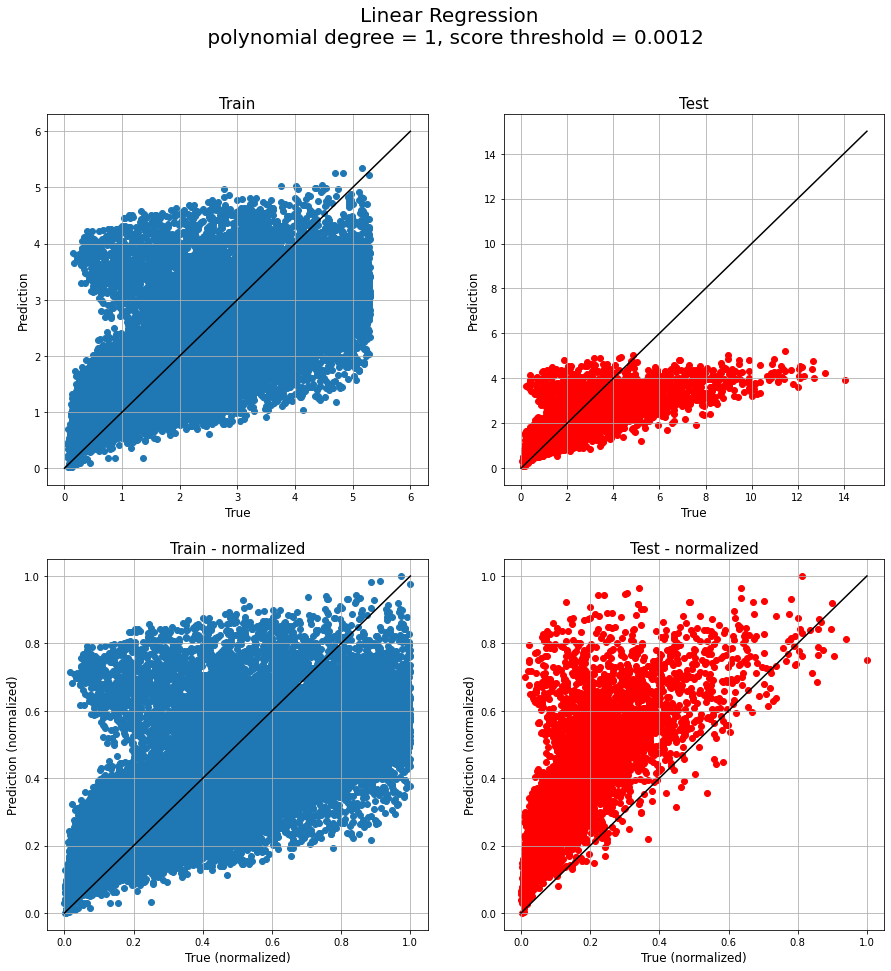


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.543022521214684
Testing MAE: 0.7506559504618218
Training MSE: 0.5713930352110558
Testing MSE: 1.514263347092093
Training R^2: 0.48052089550216837
Testing R^2: 0.4499315932893483


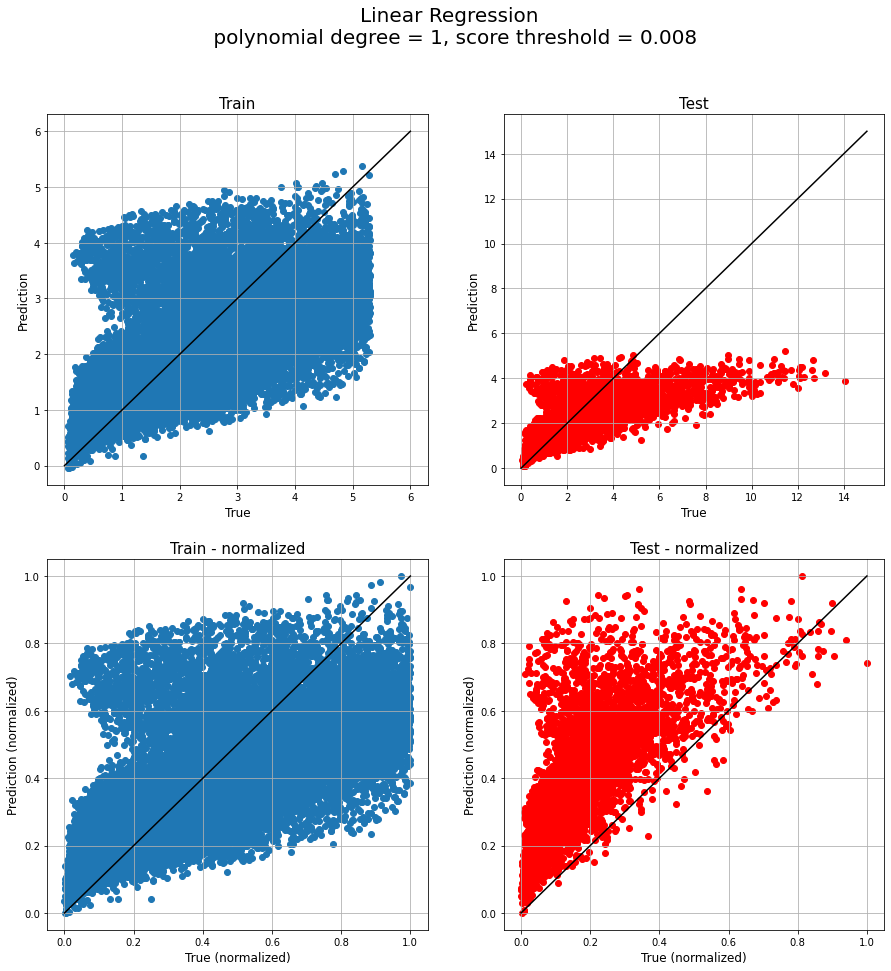


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.5440777865793915
Testing MAE: 0.7546683093260189
Training MSE: 0.5725486891974241
Testing MSE: 1.523139060349331
Training R^2: 0.47947023849210135
Testing R^2: 0.4467074186705773


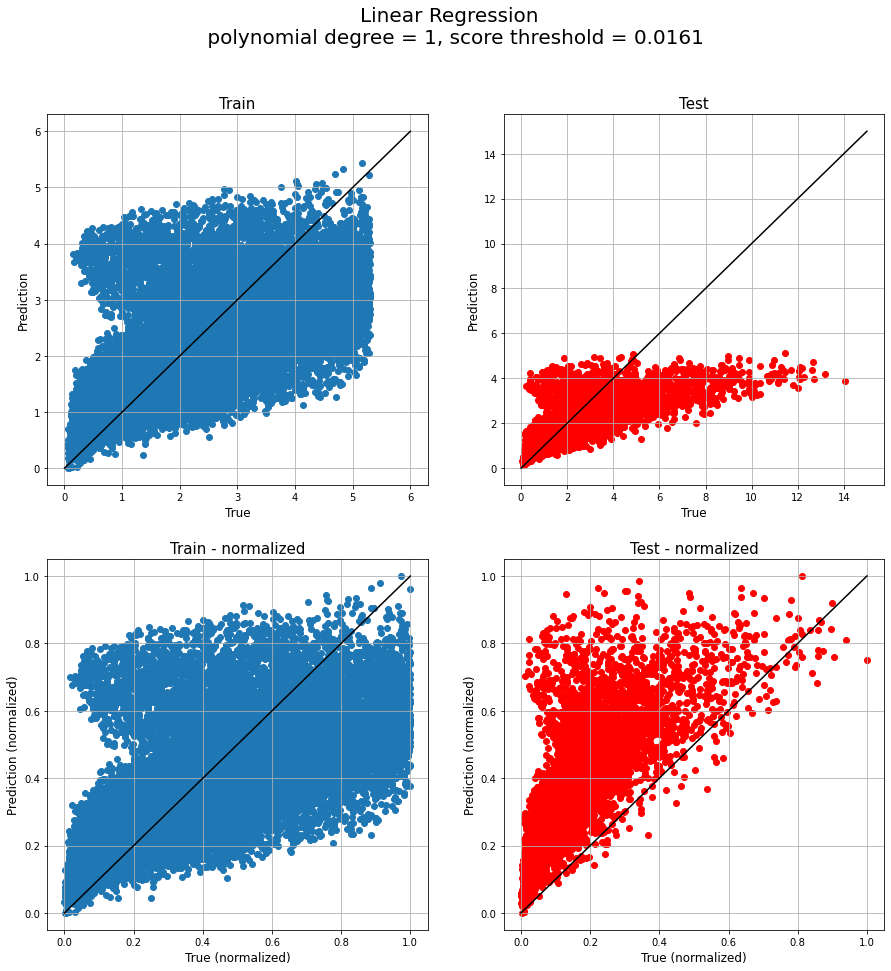


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.5440627439837907
Testing MAE: 0.754662635752263
Training MSE: 0.5725620616586469
Testing MSE: 1.5233710113809473
Training R^2: 0.4794580809862291
Testing R^2: 0.4466231605825498


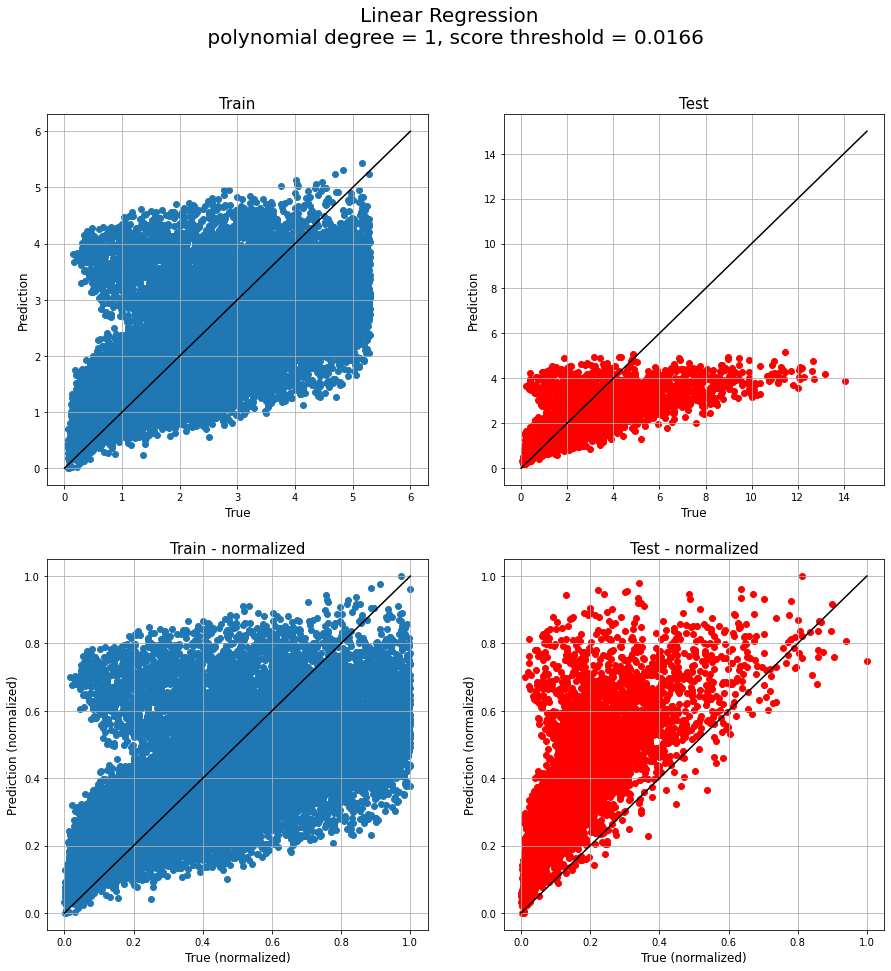


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5439867827984645
Testing MAE: 0.7569531130014655
Training MSE: 0.5732592763445892
Testing MSE: 1.5341268249931663
Training R^2: 0.4788242117607103
Testing R^2: 0.442716024305421


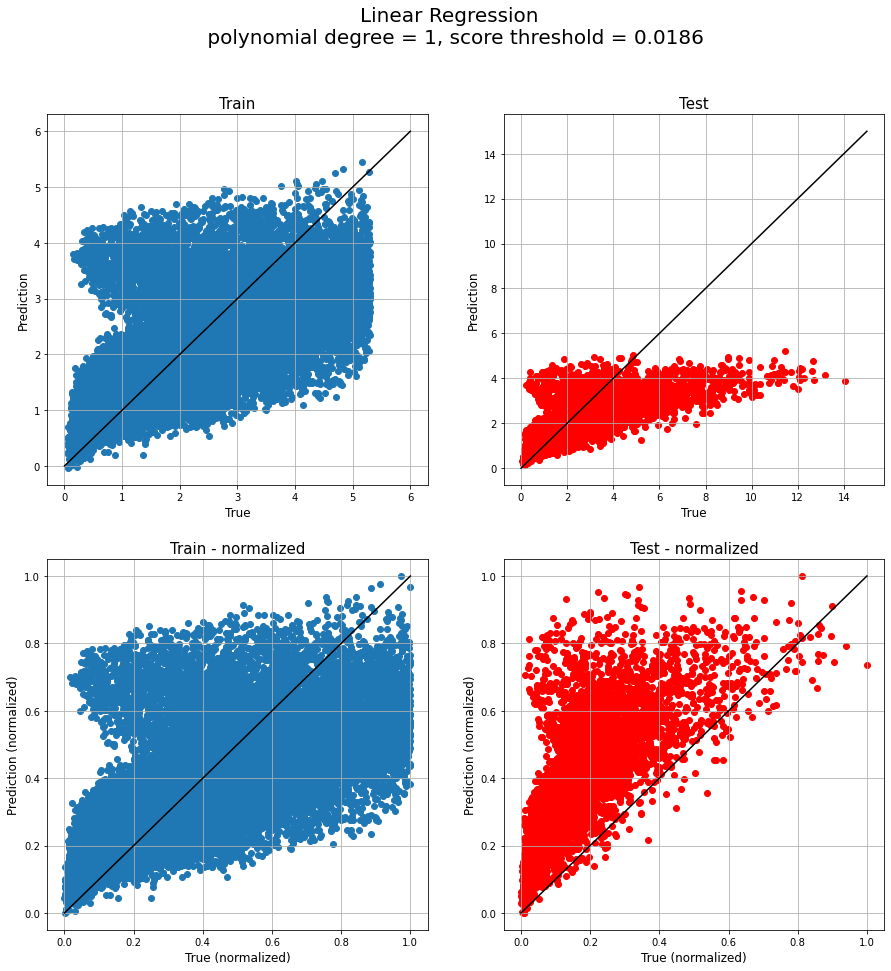


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5450151696160138
Testing MAE: 0.7574712318574712
Training MSE: 0.5767868973104207
Testing MSE: 1.5360536269804448
Training R^2: 0.4756170928995904
Testing R^2: 0.442016097901454


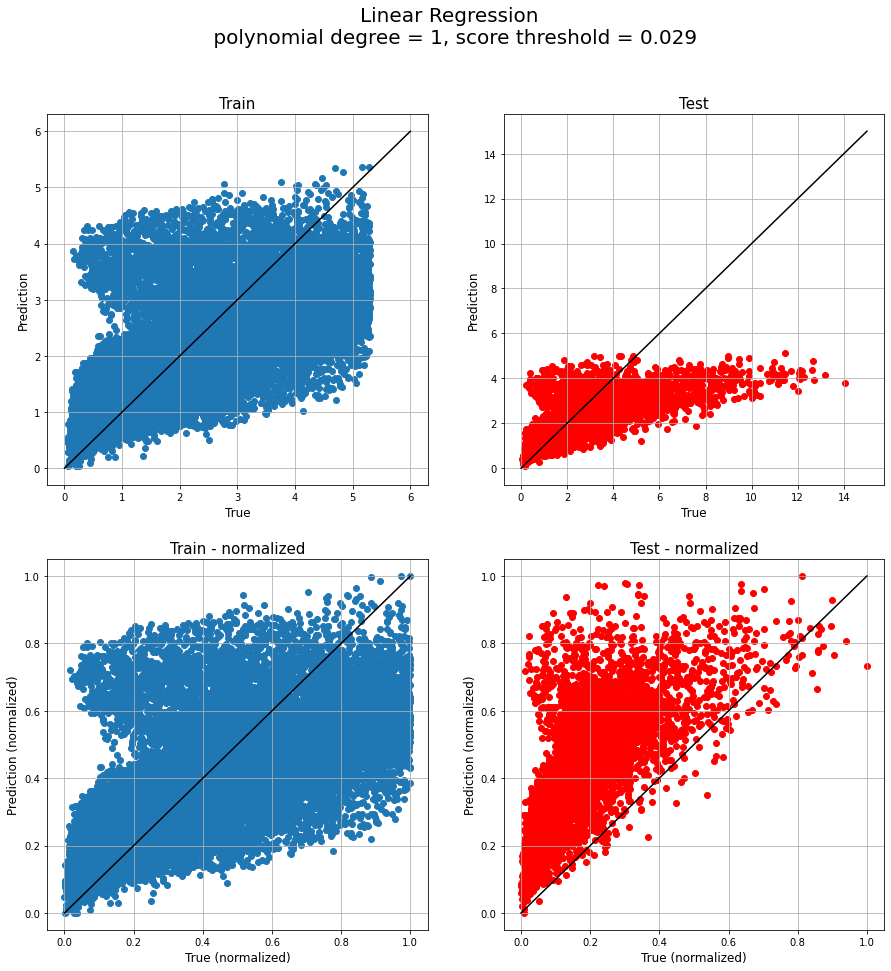


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5452434698921662
Testing MAE: 0.7573442000193059
Training MSE: 0.5774266744854873
Testing MSE: 1.5351463370962226
Training R^2: 0.47503544269823816
Testing R^2: 0.44234567828917004


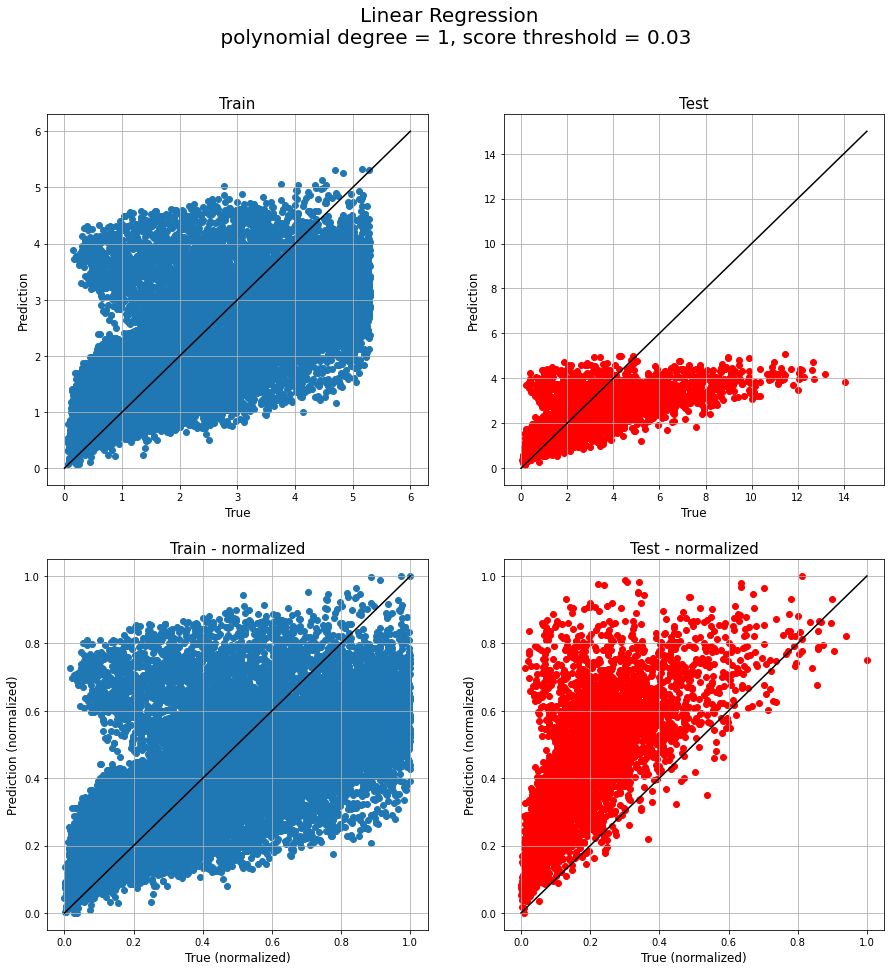


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5491483350999606
Testing MAE: 0.7677857409664957
Training MSE: 0.5848357682890323
Testing MSE: 1.570554035388823
Training R^2: 0.4682995023261539
Testing R^2: 0.4294835455415842


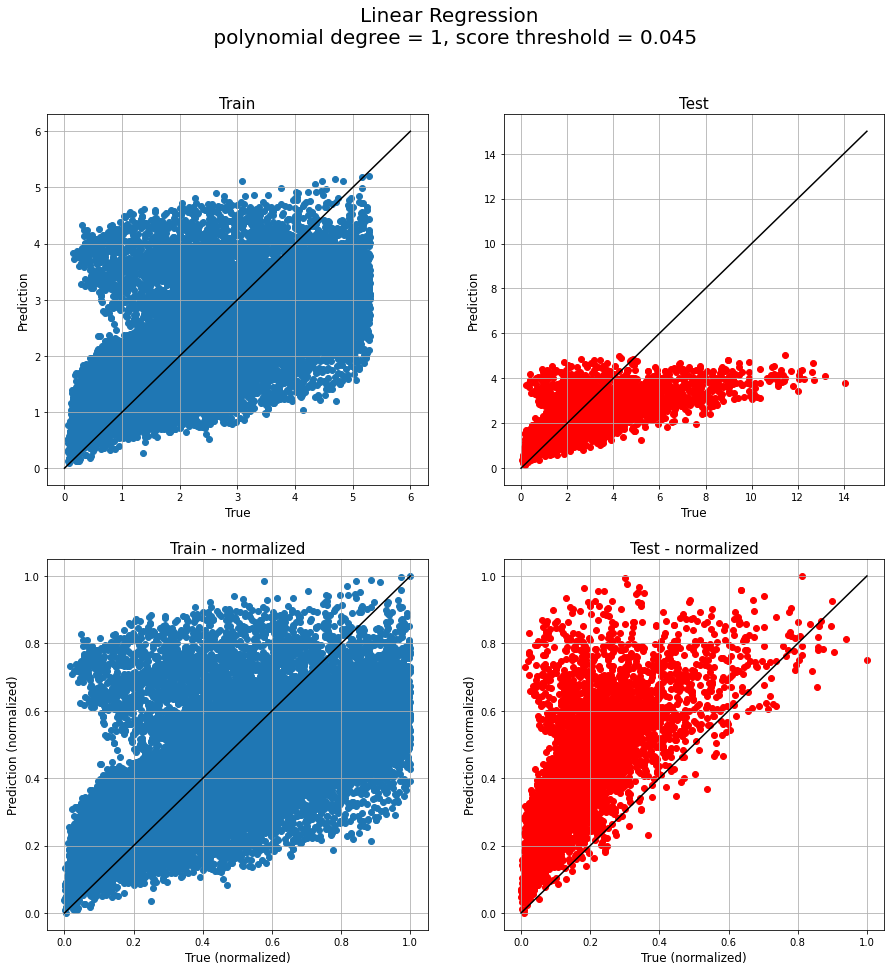


-----------------------


In [15]:
models_1 = dict()

for thr in thresholds:
    name = "thresh_" + str(thr)
    print("Relative feature selection threshold:", thr)
    models_1[name] = modelAuto(df_train, df_test, PolyDegree = 1, select_thresh = thr)
    print("")
    print("-----------------------")

models_evalution["PolyDegree_1"] = models_1

##### 4.1.2 Polynomial degree: 2

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.3385481679630639
Testing MAE: 0.5246322858065869
Training MSE: 0.2206664268881488
Testing MSE: 0.9246105023694203
Training R^2: 0.7993822276985749
Testing R^2: 0.6641277576697822


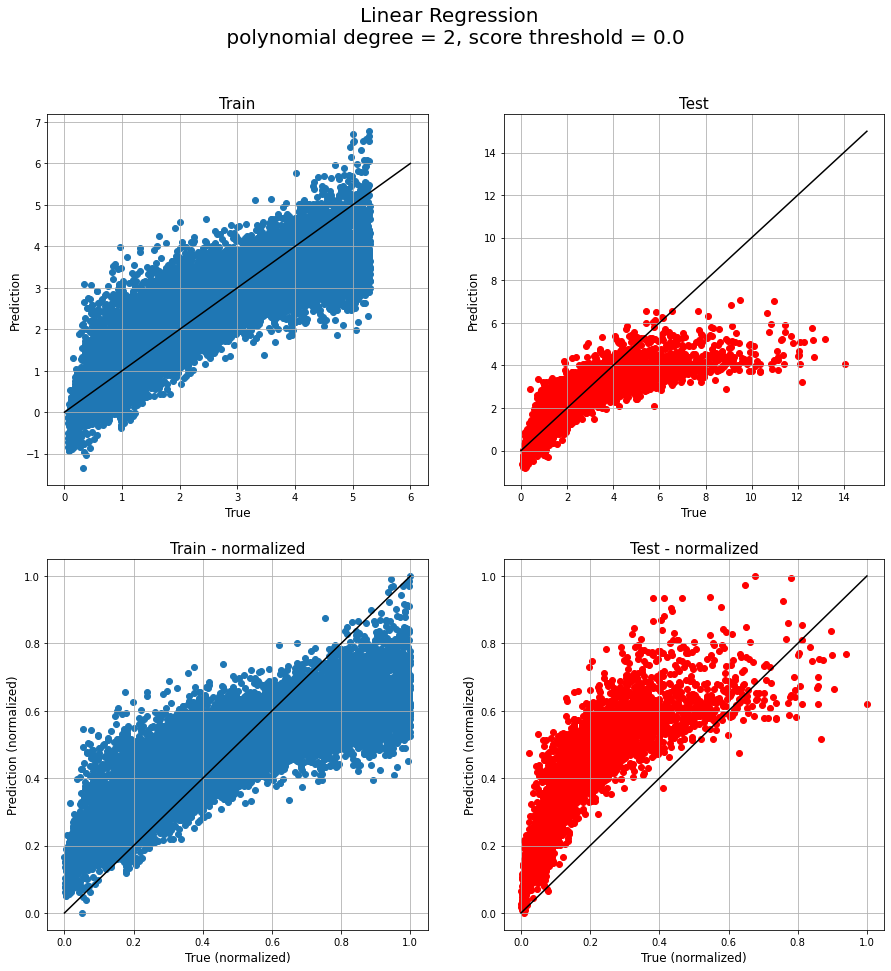


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3897170509908041
Testing MAE: 0.5701827524136446
Training MSE: 0.2802098300768079
Testing MSE: 0.9549626689310372
Training R^2: 0.7452486421259528
Testing R^2: 0.6531020877076672


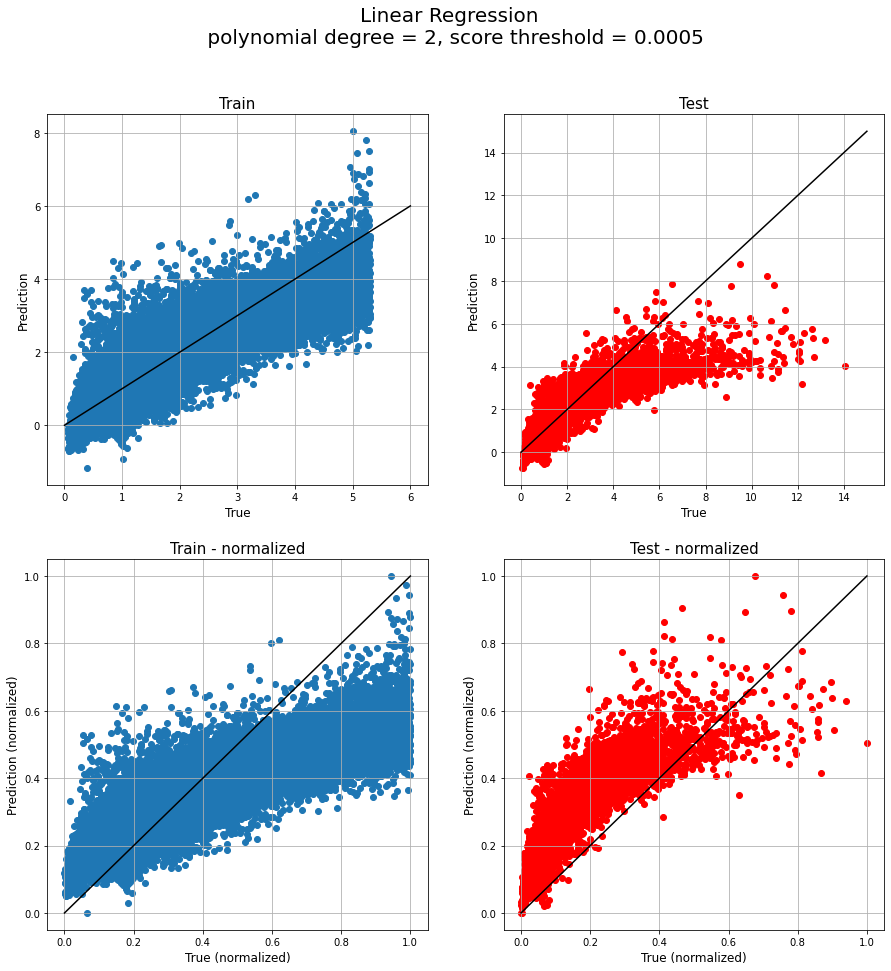


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.43772237761838395
Testing MAE: 0.6347883755346806
Training MSE: 0.35202842133625384
Testing MSE: 1.1172958565568567
Training R^2: 0.6799551310491645
Testing R^2: 0.594133244510695


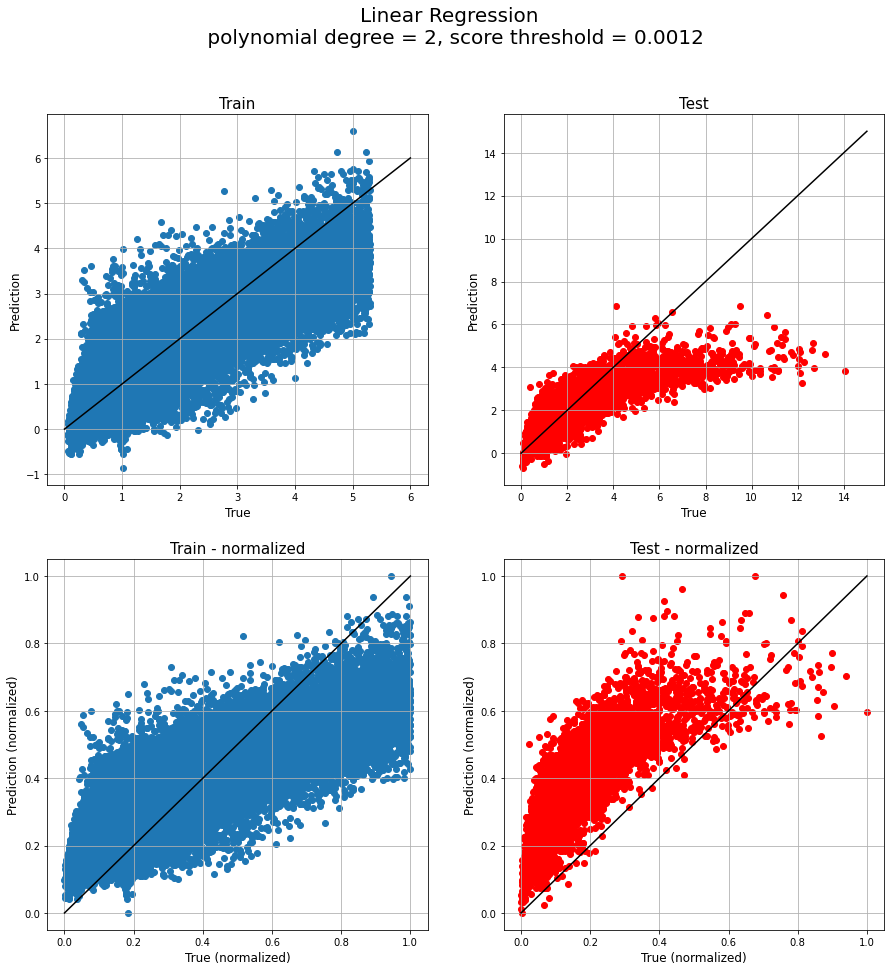


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.4408083969339133
Testing MAE: 0.6348502389999697
Training MSE: 0.3566222489963595
Testing MSE: 1.1140029060624341
Training R^2: 0.6757786757337656
Testing R^2: 0.5953294354079537


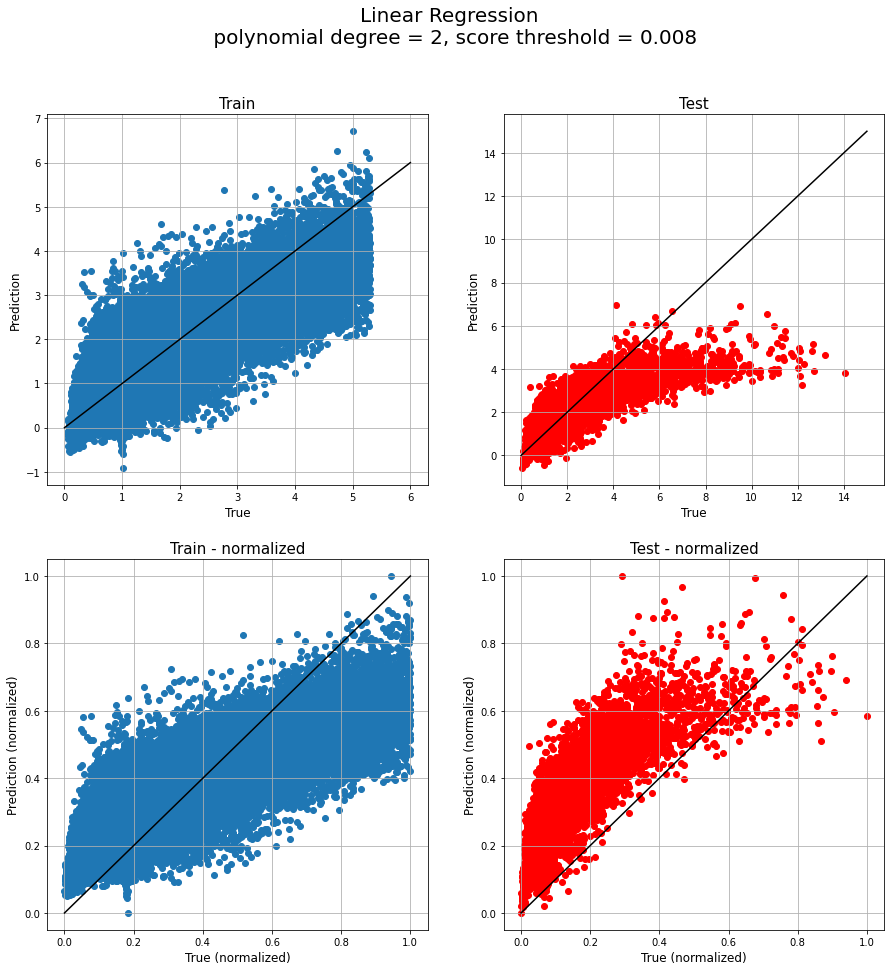


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.4510291694912202
Testing MAE: 0.652255043760614
Training MSE: 0.37265240510858283
Testing MSE: 1.198135639359483
Training R^2: 0.6612049399179933
Testing R^2: 0.5647675396546219


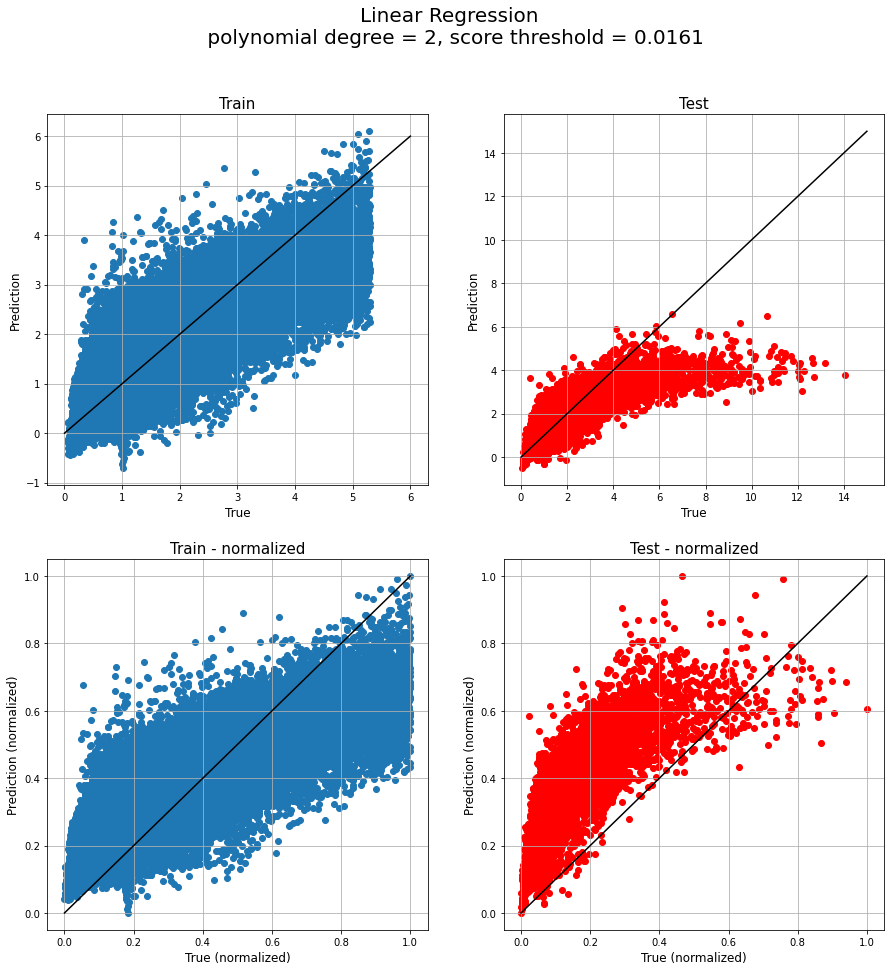


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.45257689856280847
Testing MAE: 0.6569194760625351
Training MSE: 0.37587200074358956
Testing MSE: 1.2150683561842874
Training R^2: 0.6582778607373718
Testing R^2: 0.5586165933327756


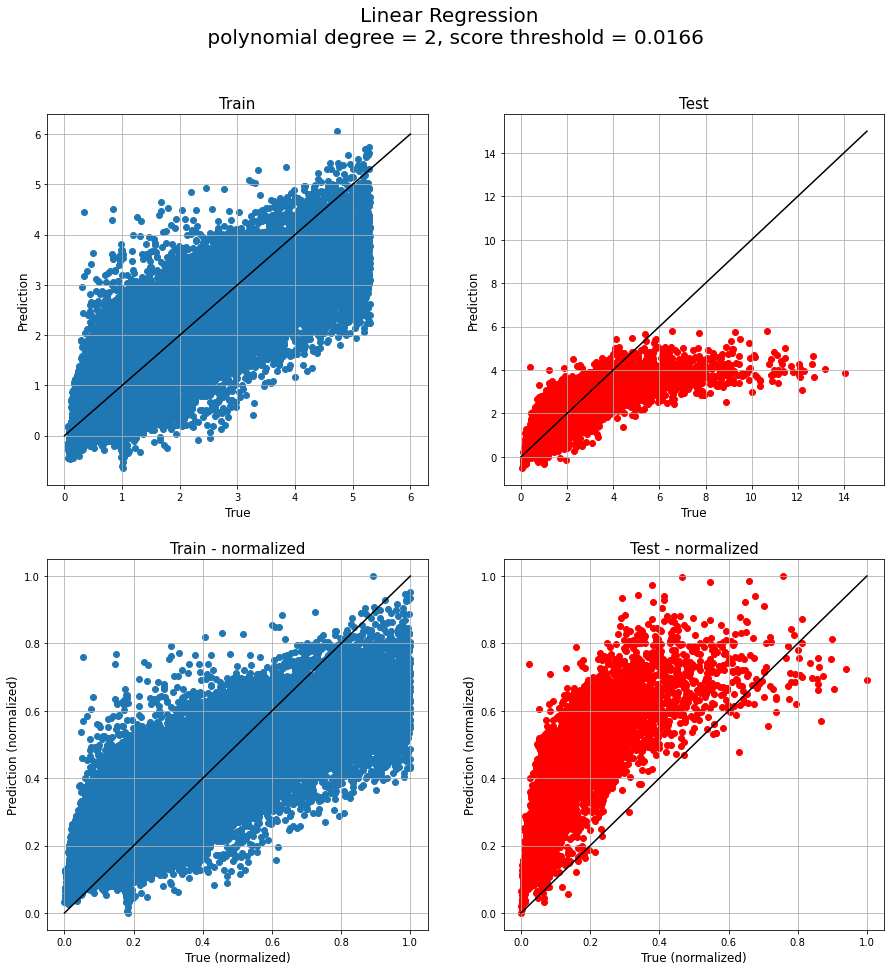


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4613139129225435
Testing MAE: 0.6651962406641004
Training MSE: 0.38803435917847695
Testing MSE: 1.2341237905867706
Training R^2: 0.6472205137292775
Testing R^2: 0.551694552684376


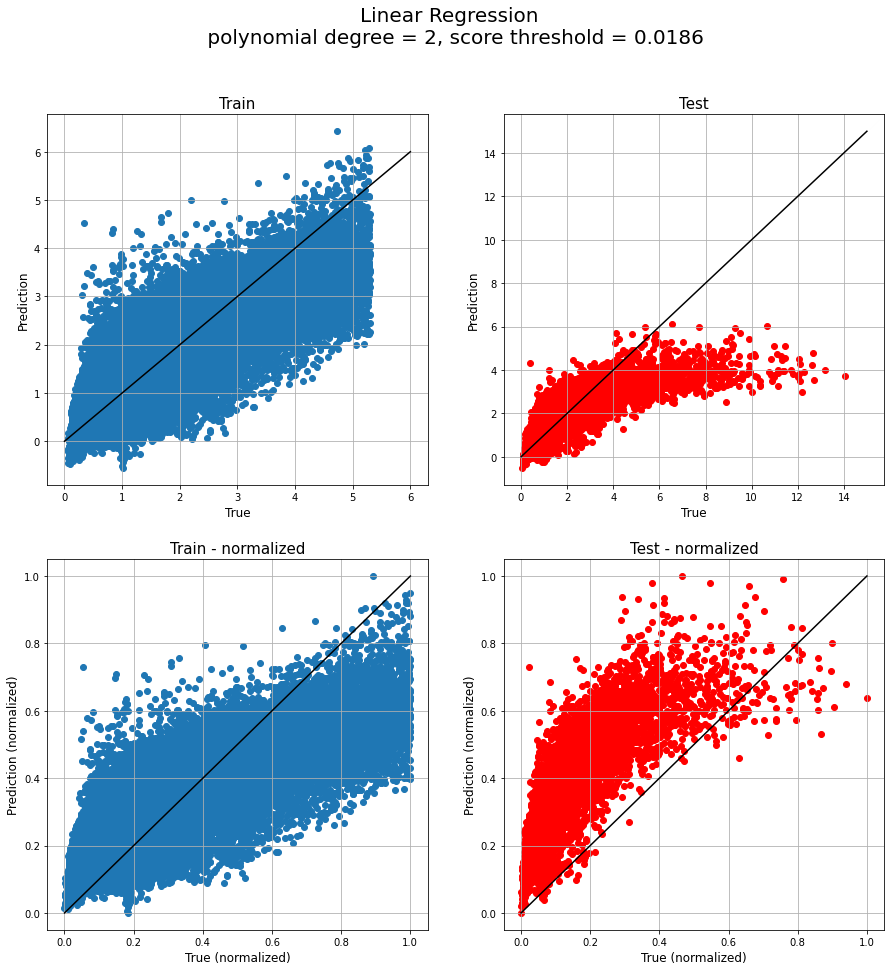


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4644477947743515
Testing MAE: 0.6694040482877014
Training MSE: 0.39523316662219676
Testing MSE: 1.2495357566482839
Training R^2: 0.6406757541437242
Testing R^2: 0.5460960313756384


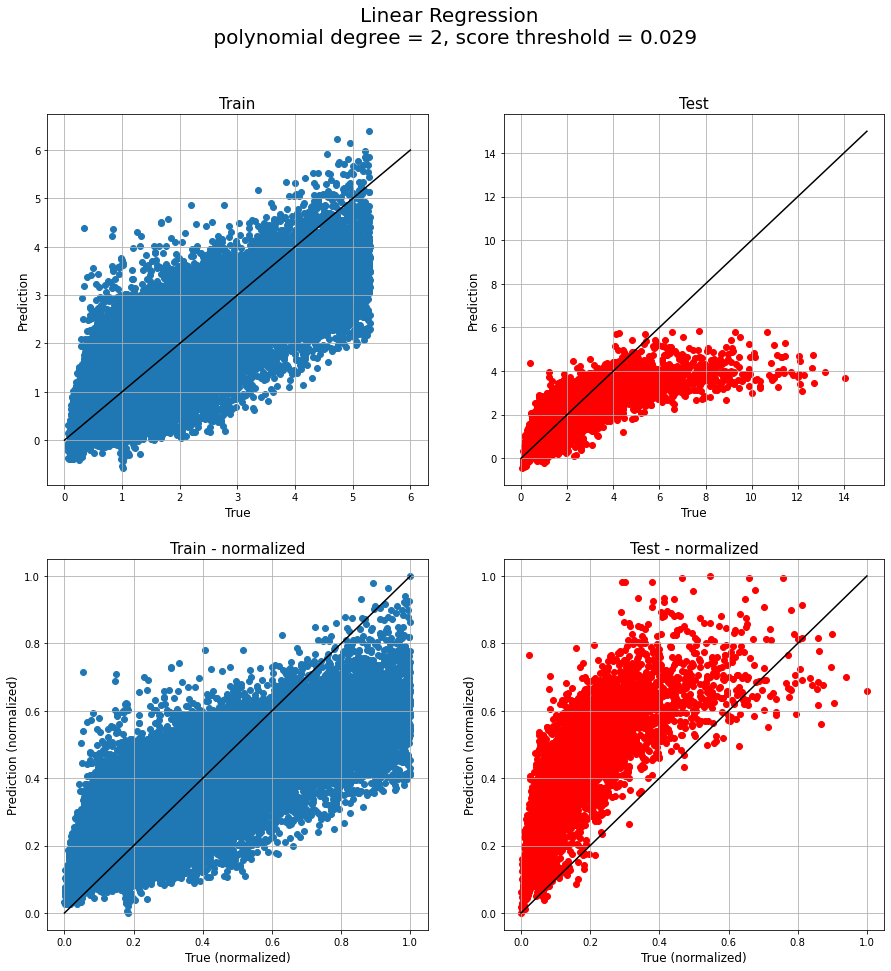


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4655632338097295
Testing MAE: 0.6686539856815169
Training MSE: 0.3980706083269456
Testing MSE: 1.2457950675215523
Training R^2: 0.6380961082869923
Testing R^2: 0.547454866951955


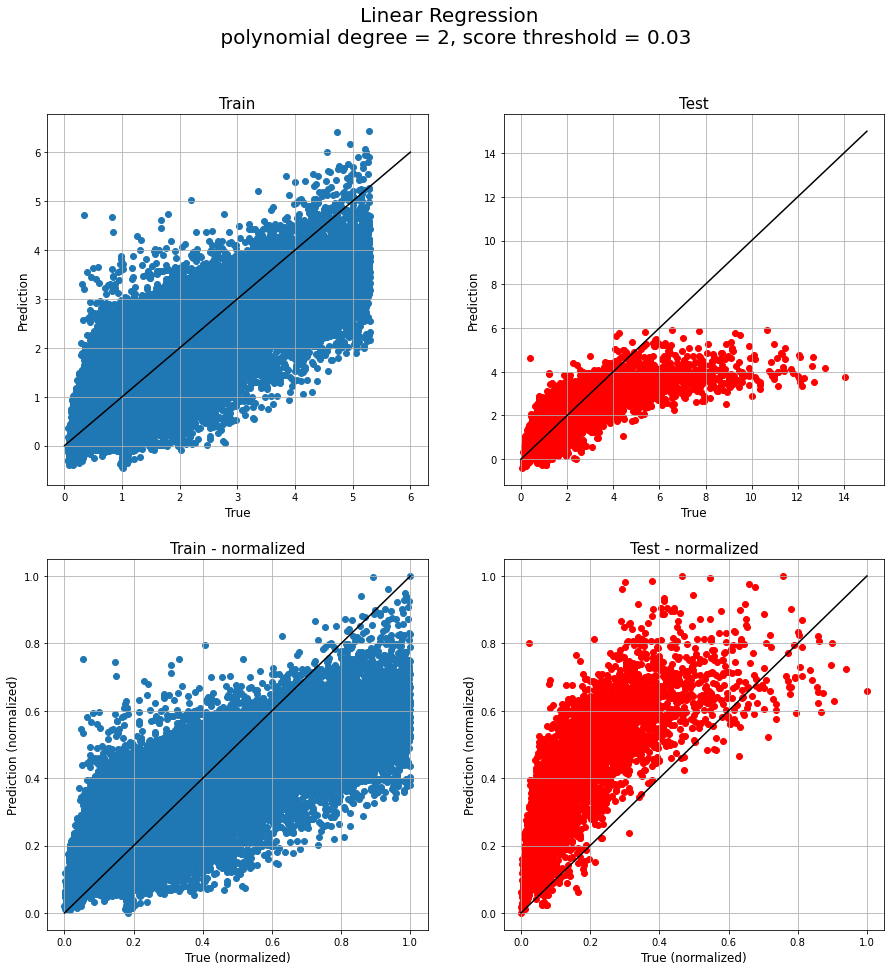


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4736906516361394
Testing MAE: 0.6917600249206444
Training MSE: 0.41248107865119965
Testing MSE: 1.3385643839244956
Training R^2: 0.6249949016601544
Testing R^2: 0.5137556625411783


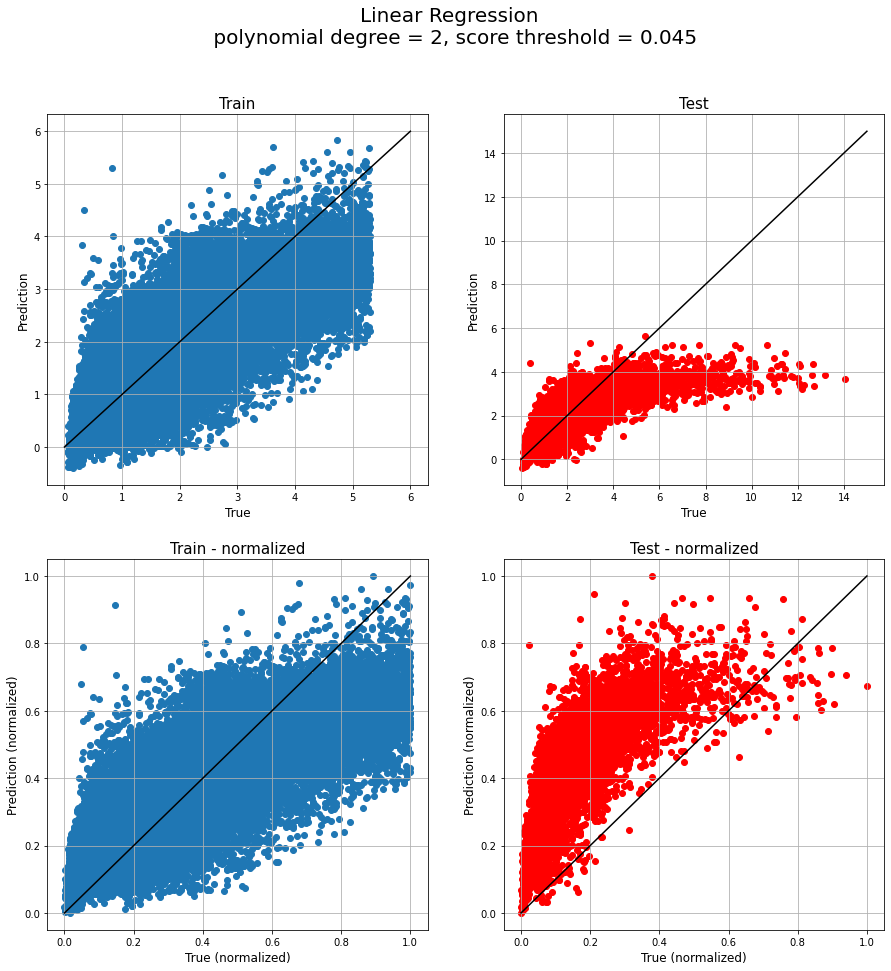


-----------------------


In [16]:
models_2 = dict()

for thr in thresholds:
    name = "thresh_" + str(thr)
    print("Relative feature selection threshold:", thr)
    models_2[name] = modelAuto(df_train, df_test, PolyDegree = 2, select_thresh = thr)
    print("")
    print("-----------------------")

models_evalution["PolyDegree_2"] = models_2

##### 4.1.3 Polynomial degree: 3

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.18184507554158924
Testing MAE: 0.3029794385158454
Training MSE: 0.0717626868150528
Testing MSE: 0.37573091502850525
Training R^2: 0.9347573141676953
Testing R^2: 0.8635127065721049


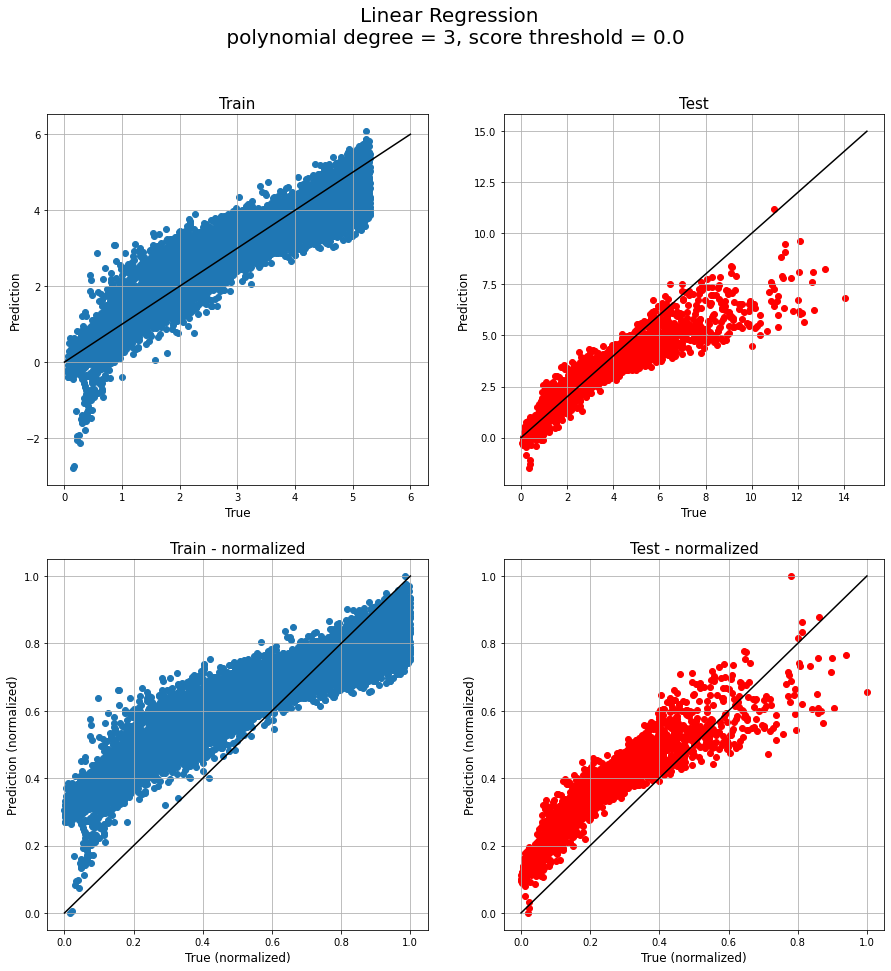


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.22887511784082618
Testing MAE: 0.35341294688656166
Training MSE: 0.1076949900481383
Testing MSE: 0.4516165530951237
Training R^2: 0.9020896413824063
Testing R^2: 0.835946634855659


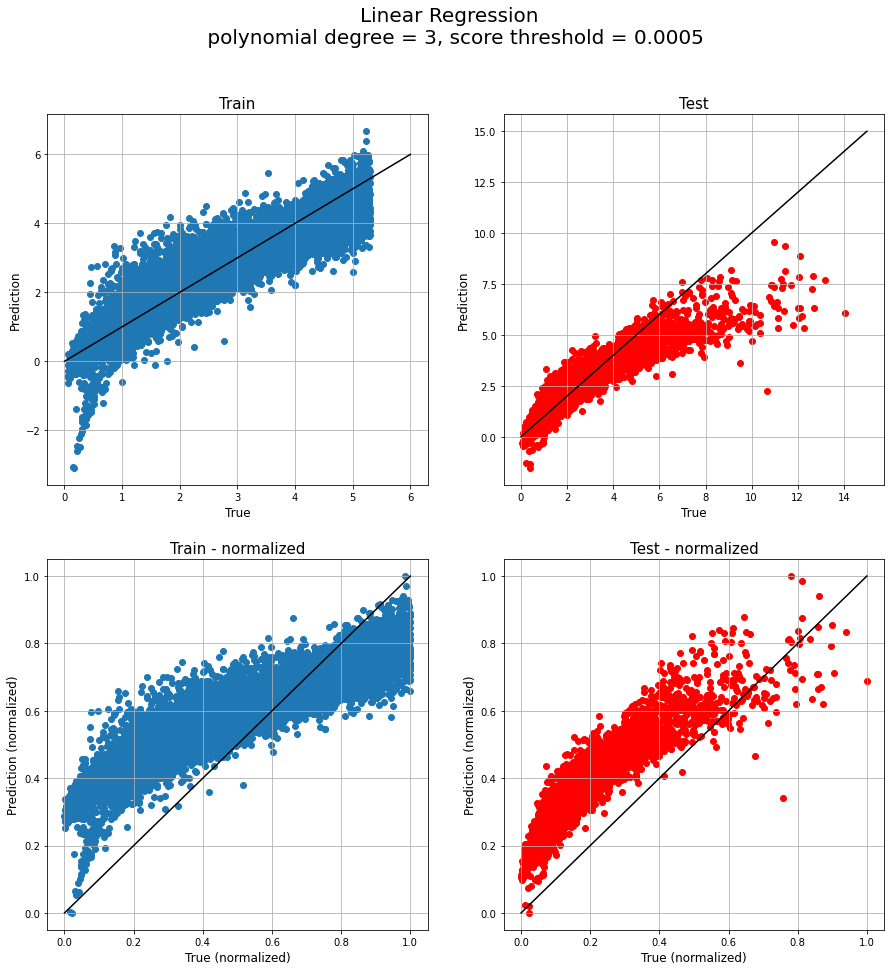


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3289636913165862
Testing MAE: 0.49027351152091475
Training MSE: 0.22172063290952834
Testing MSE: 0.671852685082609
Training R^2: 0.7984238015957082
Testing R^2: 0.7559440788569862


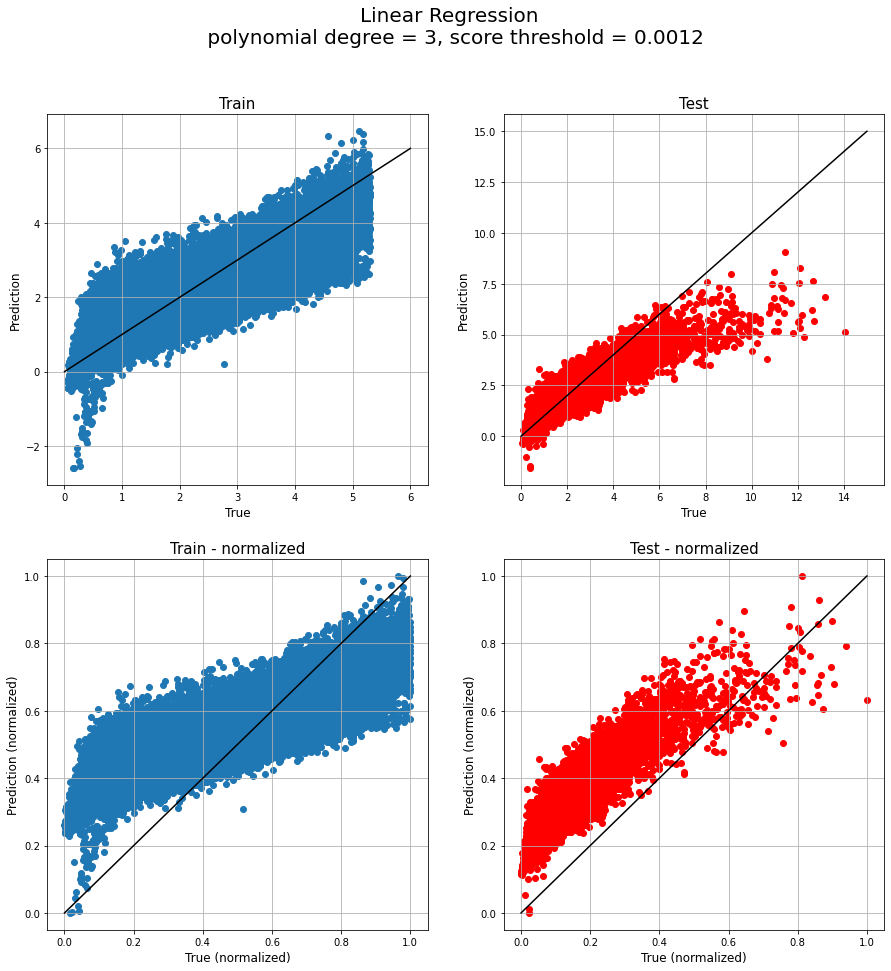


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3334171760757929
Testing MAE: 0.49316237202224594
Training MSE: 0.22595079342913785
Testing MSE: 0.6725396036799282
Training R^2: 0.7945779724322548
Testing R^2: 0.755694550121385


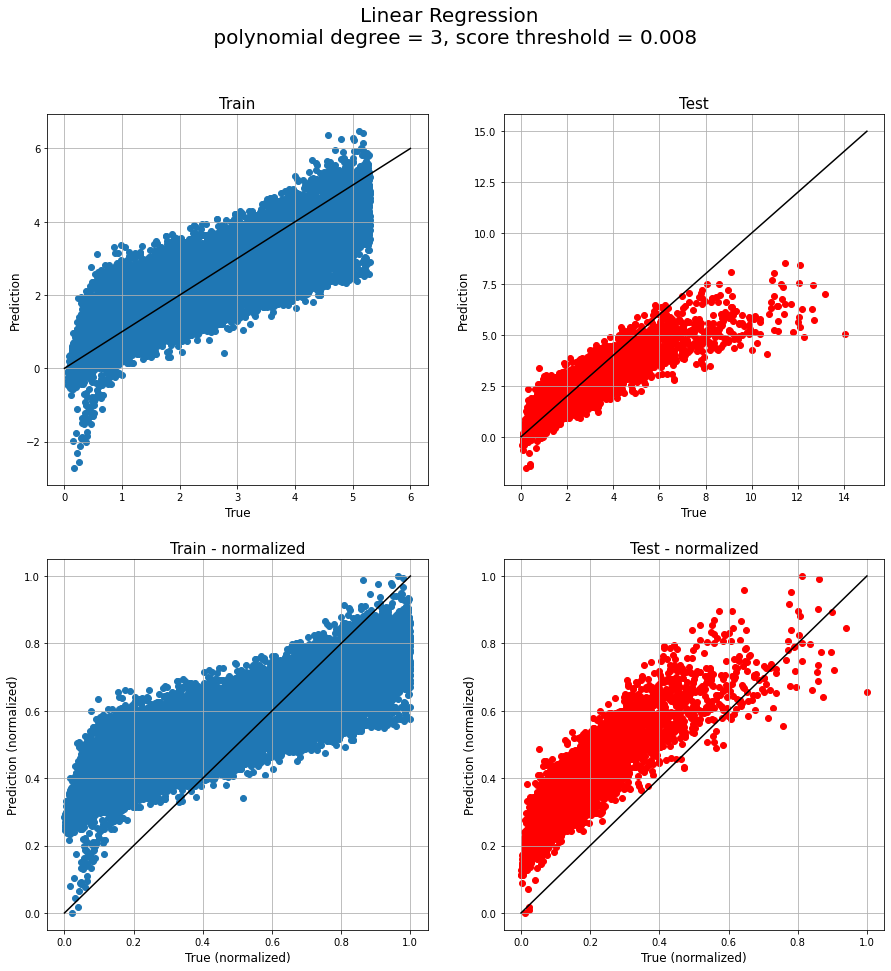


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3577129153074803
Testing MAE: 0.5329335098541573
Training MSE: 0.25852785922434324
Testing MSE: 0.8120251210381719
Training R^2: 0.7649606968905441
Testing R^2: 0.7050253079186983


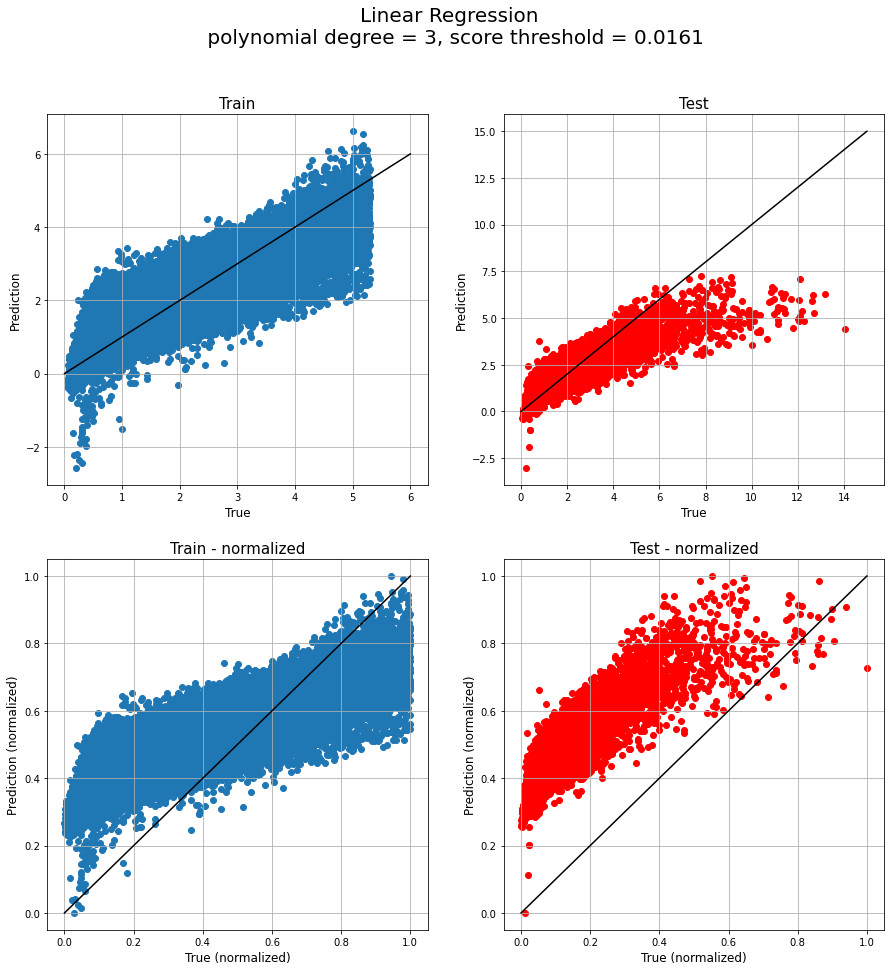


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.35576631355248634
Testing MAE: 0.5306034712001155
Training MSE: 0.2573915776990351
Testing MSE: 0.8049924616153824
Training R^2: 0.7659937415250601
Testing R^2: 0.7075799783272909


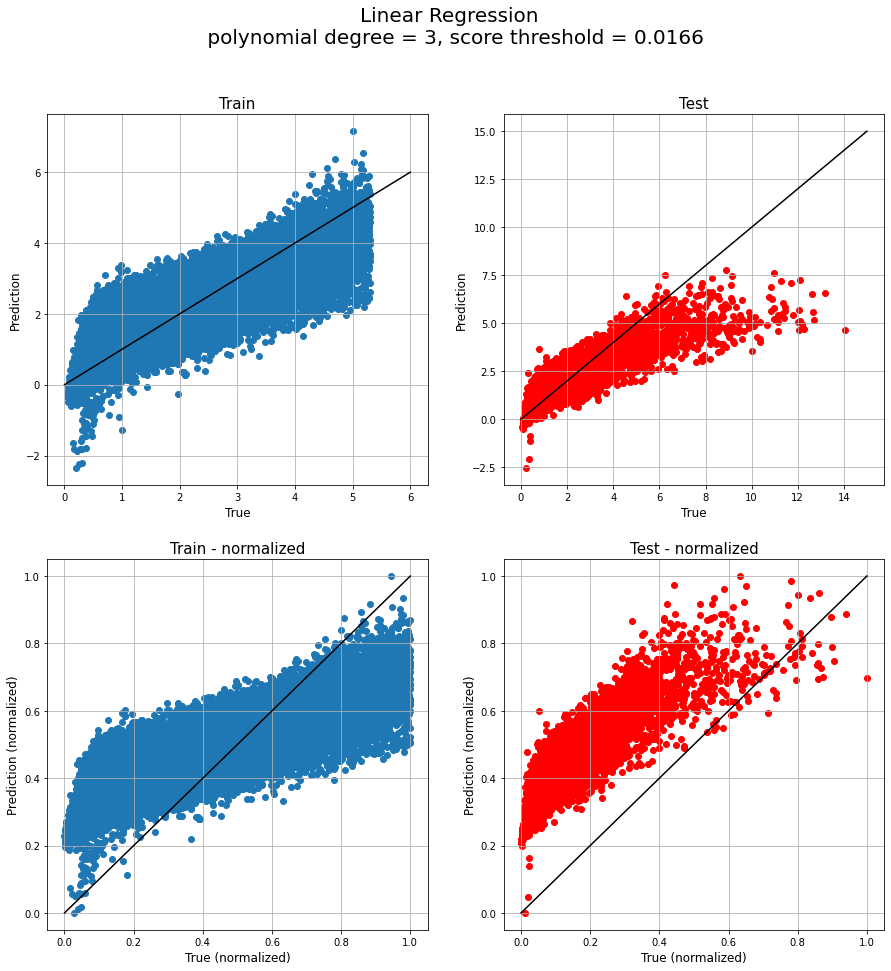


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3582539035847087
Testing MAE: 0.5345240370521648
Training MSE: 0.2614556783763692
Testing MSE: 0.8175637618969536
Training R^2: 0.762298884832117
Testing R^2: 0.7030133518356412


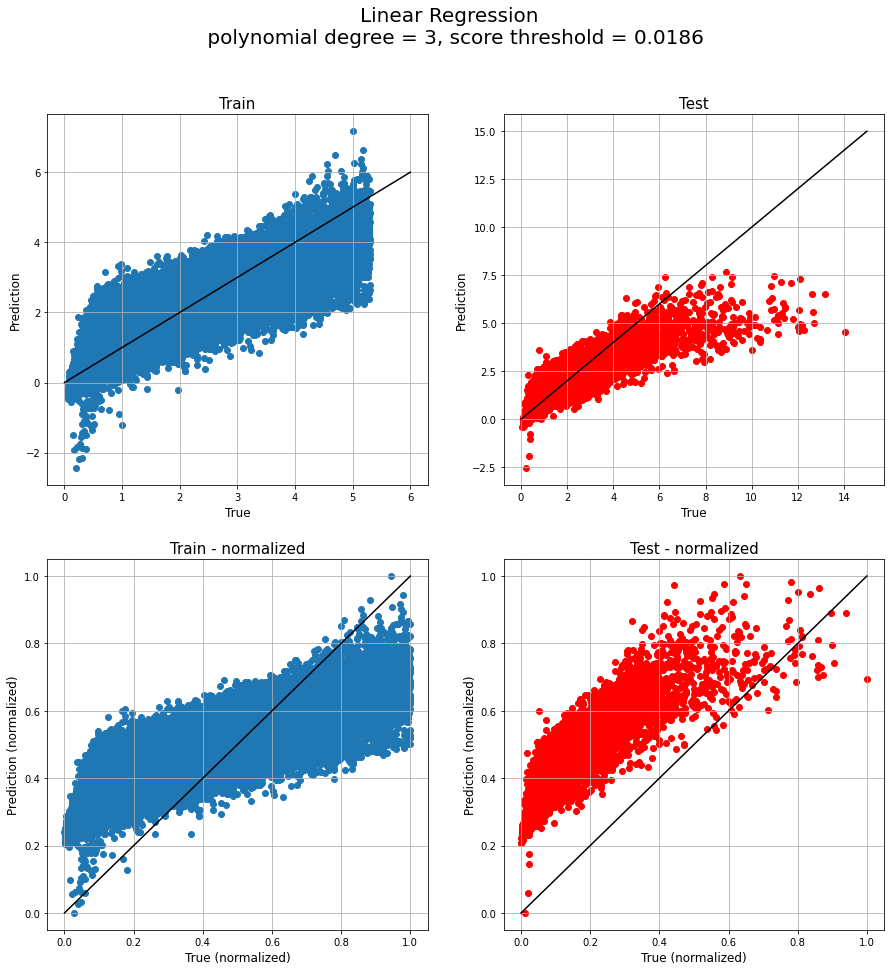


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.36543819404235545
Testing MAE: 0.5436424823654851
Training MSE: 0.27372311754751416
Testing MSE: 0.8481022267717712
Training R^2: 0.751146004201092
Testing R^2: 0.6919200075046577


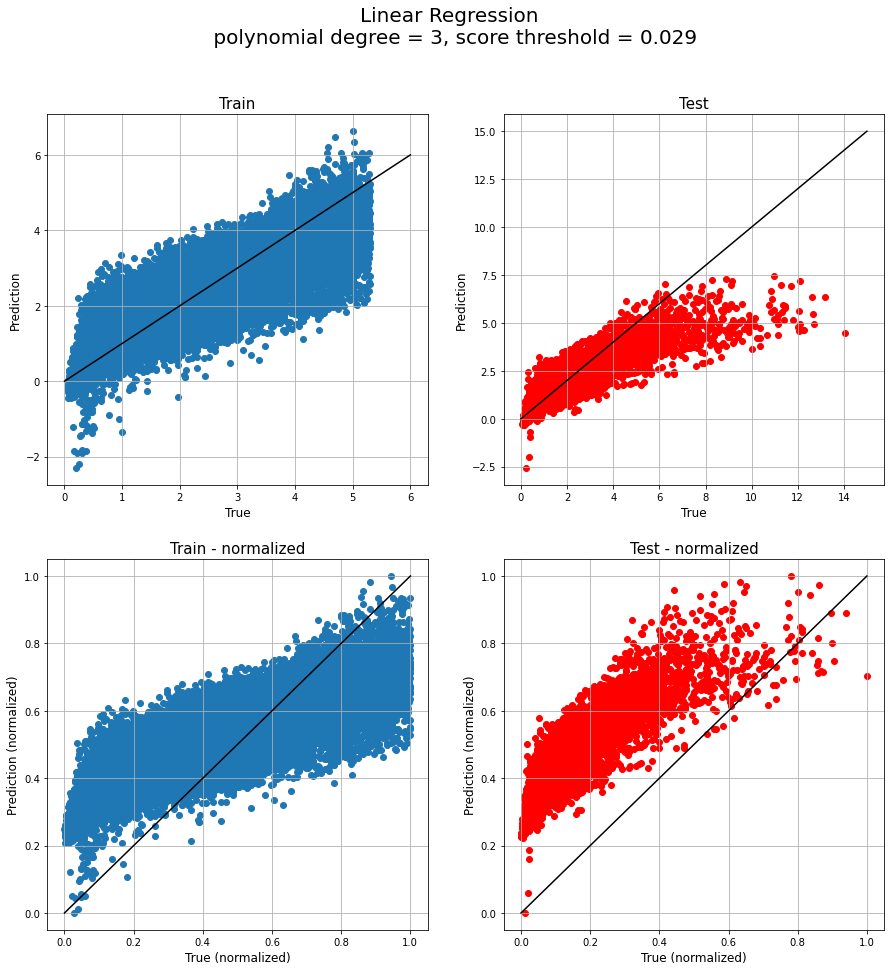


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3697378949849734
Testing MAE: 0.5471400540443437
Training MSE: 0.2828793671921976
Testing MSE: 0.8682525093218219
Training R^2: 0.7428216458822654
Testing R^2: 0.6846002544125942


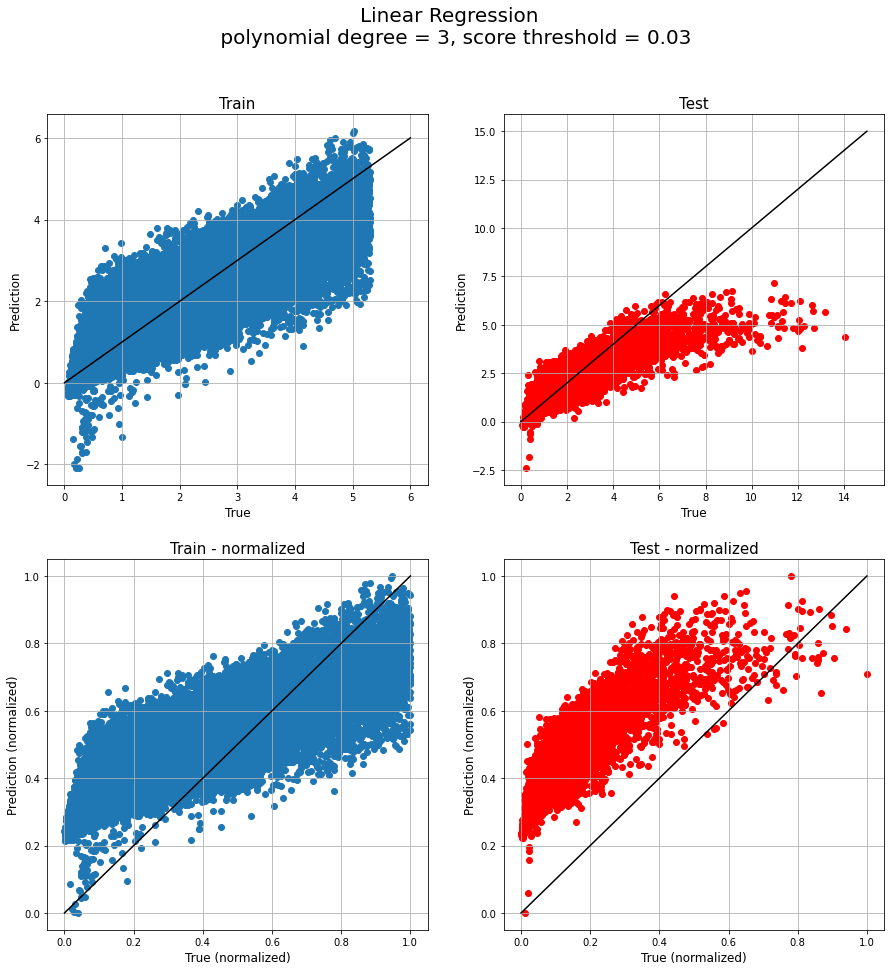


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3905676922316806
Testing MAE: 0.5949178580818051
Training MSE: 0.3166193183568211
Testing MSE: 1.026733302240571
Training R^2: 0.7121471389549536
Testing R^2: 0.6270308247473622


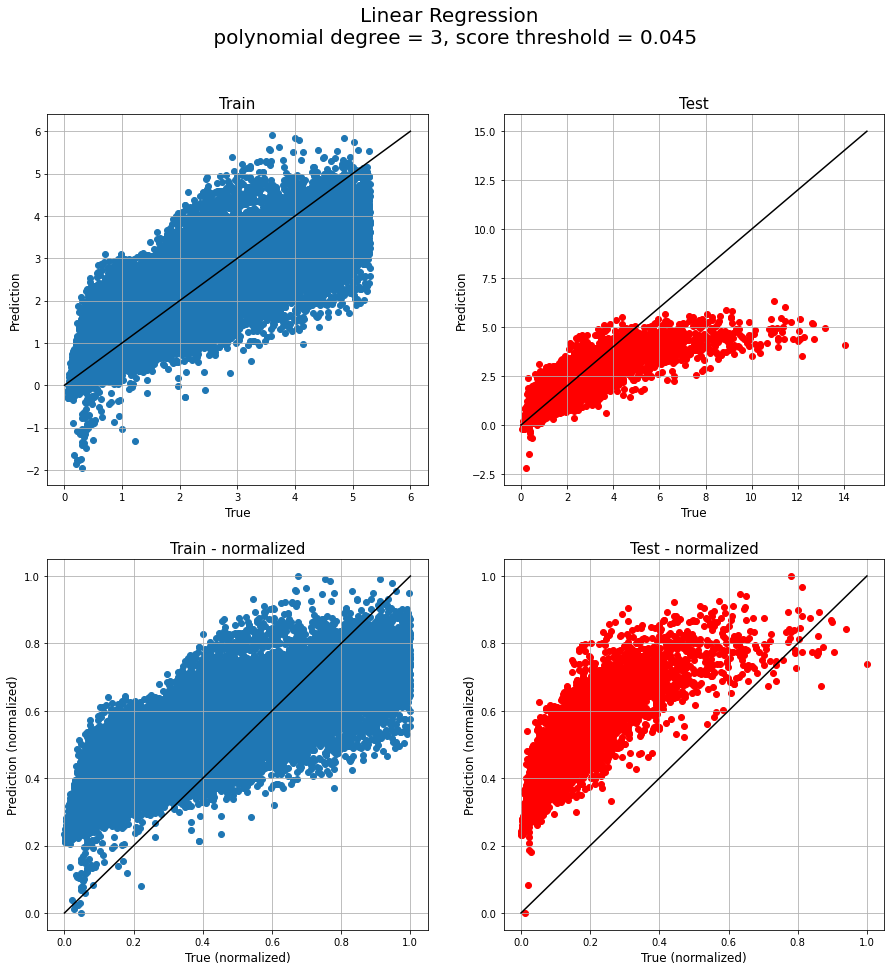


-----------------------


In [17]:
models_3 = dict()

for thr in thresholds:
    name = "thresh_" + str(thr)
    print("Relative feature selection threshold:", thr)
    models_3[name] = modelAuto(df_train, df_test, PolyDegree = 3, select_thresh = thr)
    print("")
    print("-----------------------")

models_evalution["PolyDegree_3"] = models_3

##### 4.1.4 Polynomial degree: 4

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.1121693140488222
Testing MAE: 0.2331468050188898
Training MSE: 0.03036618196834907
Testing MSE: 0.2805311980184982
Training R^2: 0.9723927383712168
Testing R^2: 0.8980947736580981


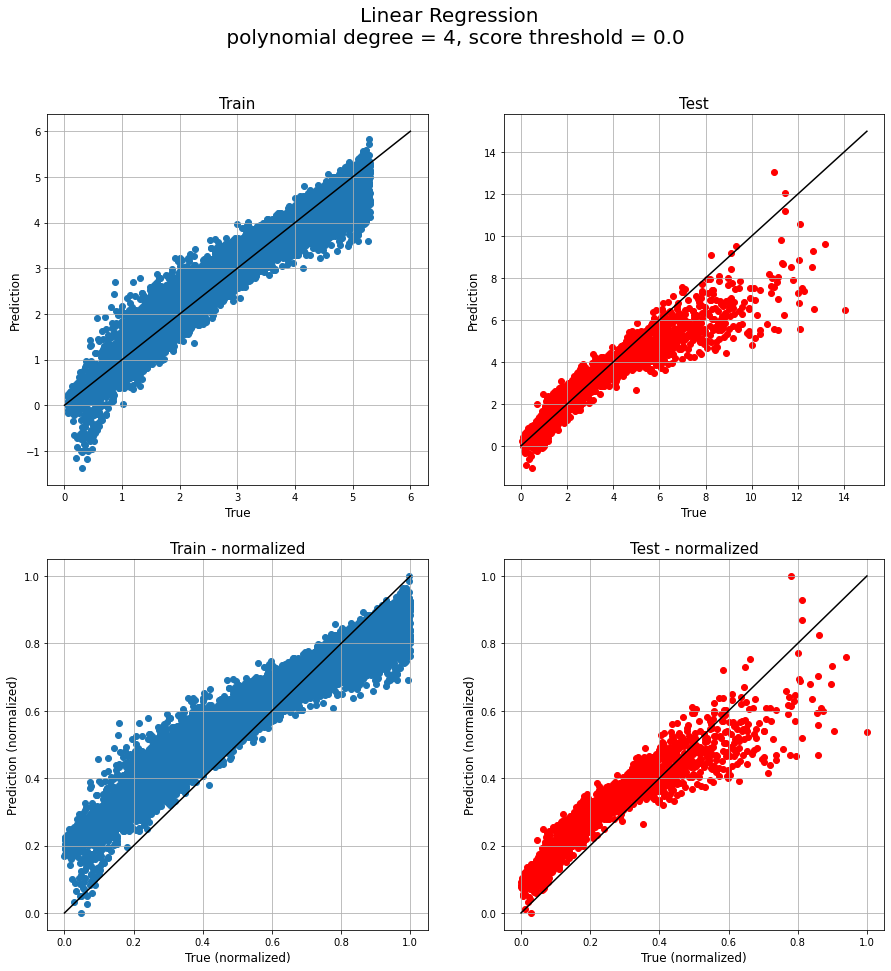


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.15089515314207824
Testing MAE: 0.25584864986536676
Training MSE: 0.0506404700904333
Testing MSE: 0.2762760578212193
Training R^2: 0.9539604712818899
Testing R^2: 0.8996404877461678


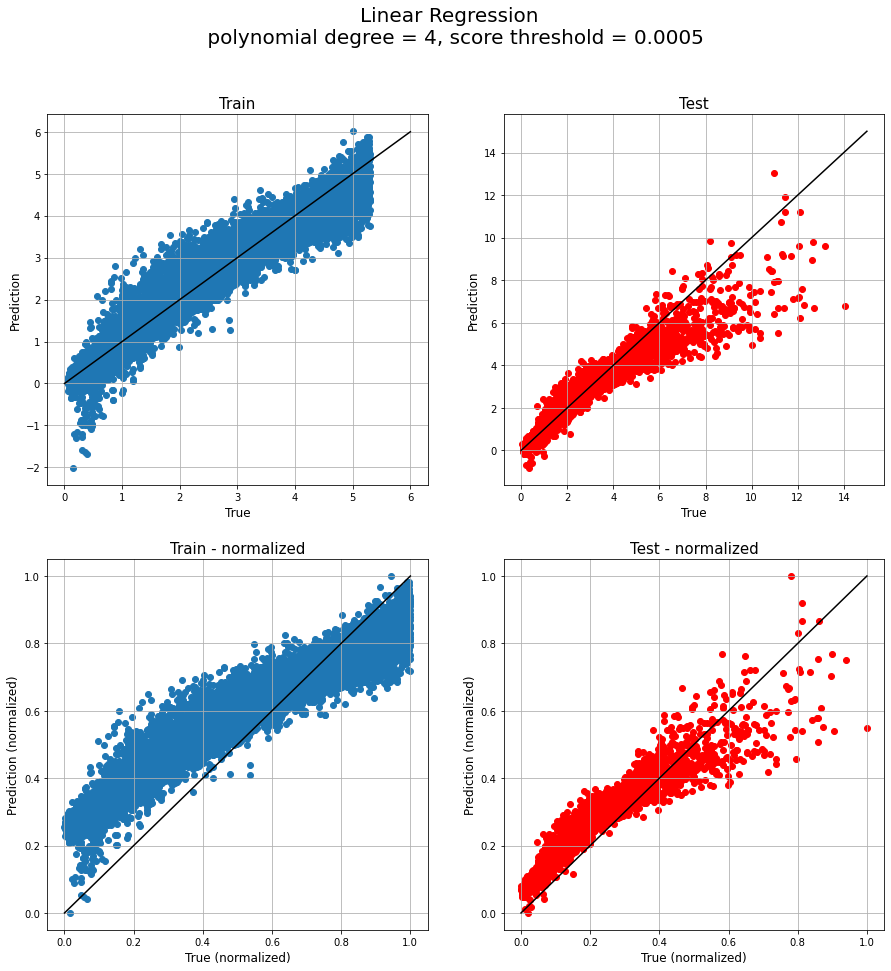


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.28703274315081534
Testing MAE: 0.44675344683129703
Training MSE: 0.18071810326972892
Testing MSE: 0.5613669182031431
Training R^2: 0.8357010452211249
Testing R^2: 0.7960789271766664


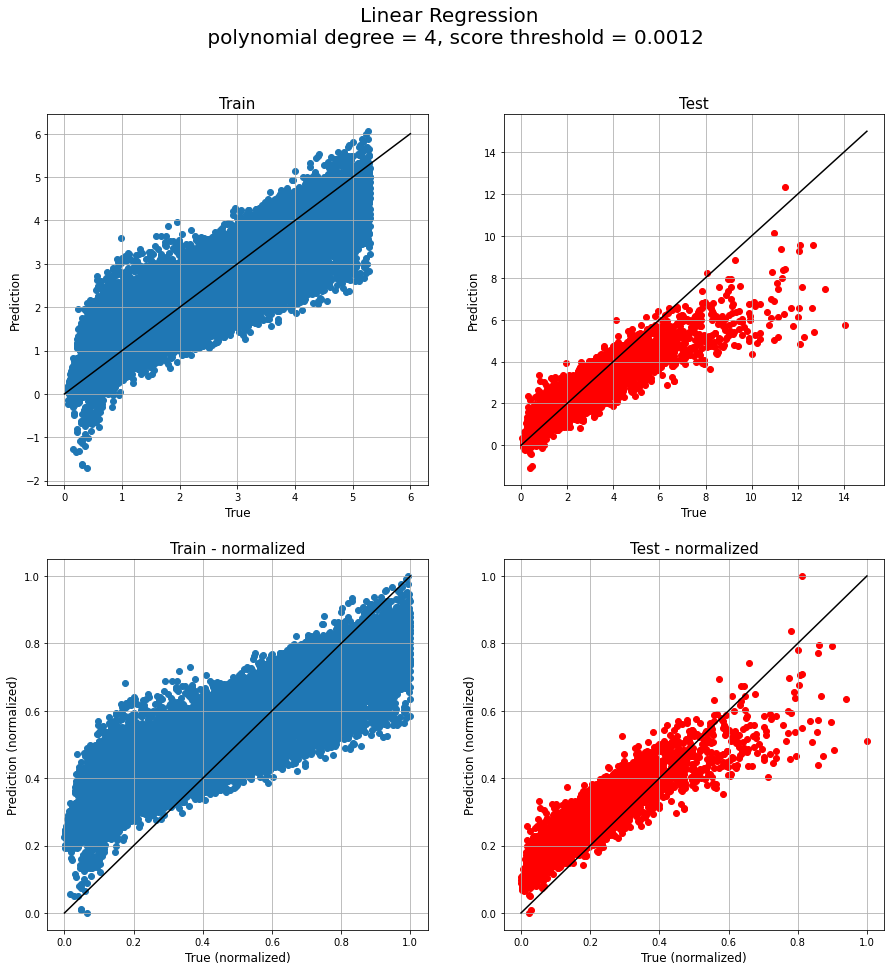


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.2877963195792507
Testing MAE: 0.4450110520262005
Training MSE: 0.18183537606344322
Testing MSE: 0.5672468485231236
Training R^2: 0.8346852822793451
Testing R^2: 0.7939429949368135


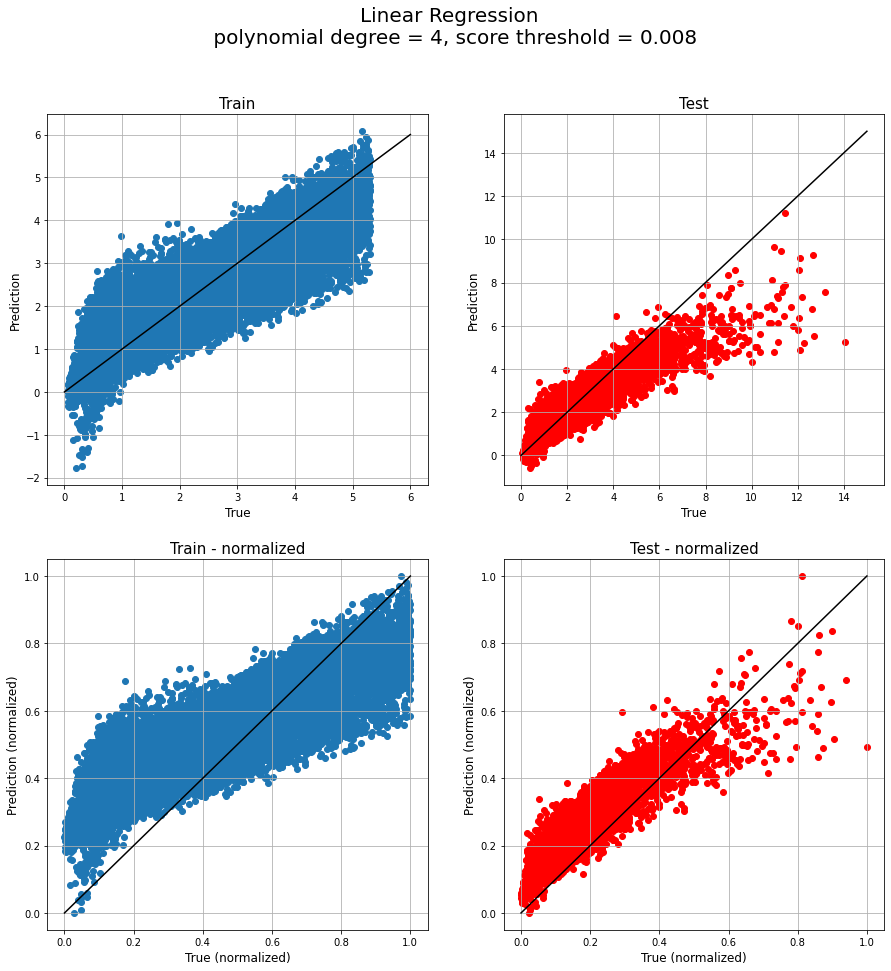


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3167015816902205
Testing MAE: 0.4992055740310697
Training MSE: 0.21611848954821045
Testing MSE: 0.7671737785234469
Training R^2: 0.8035169620601703
Testing R^2: 0.7213179208009198


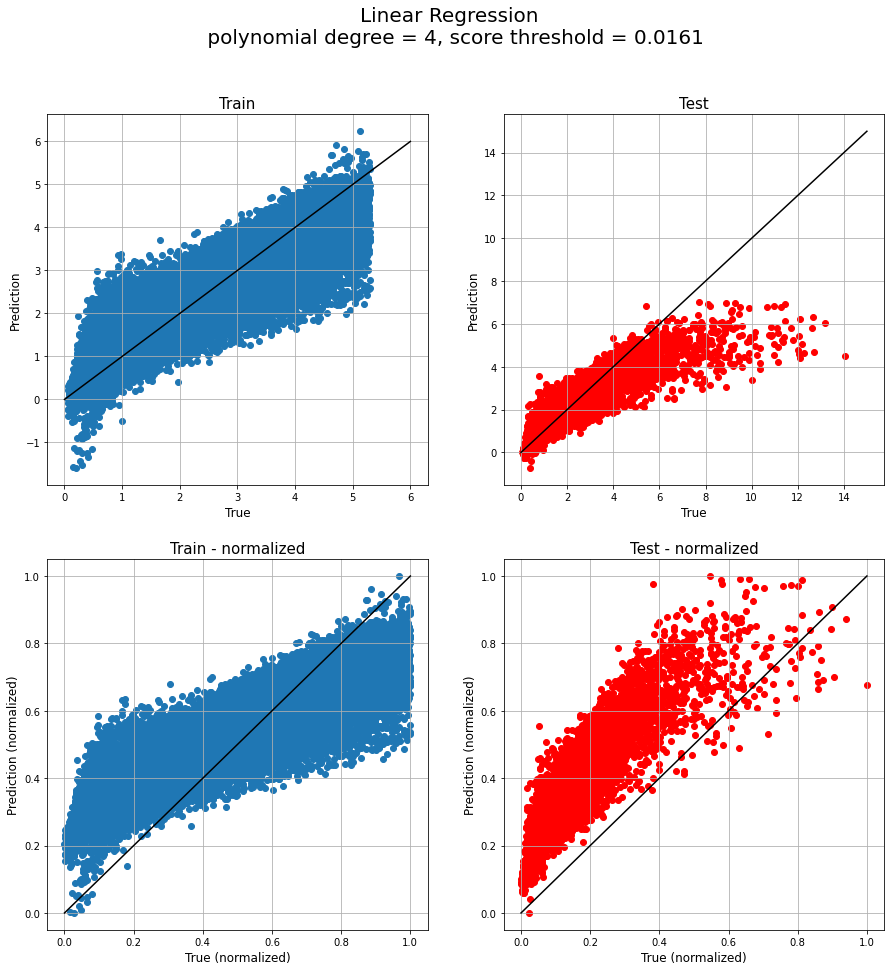


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.3163214328160436
Testing MAE: 0.49901464542380447
Training MSE: 0.21701629956117308
Testing MSE: 0.7703403409292452
Training R^2: 0.8027007226018599
Testing R^2: 0.7201676413989571


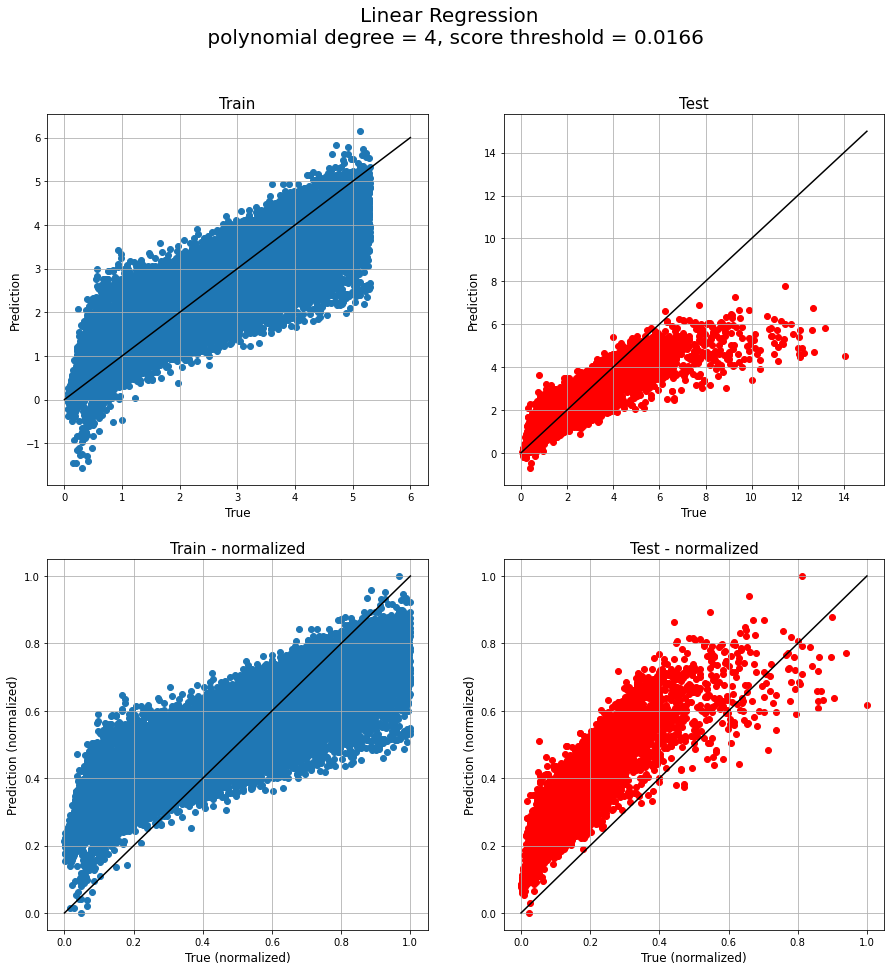


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.32019937065364695
Testing MAE: 0.5002517282565958
Training MSE: 0.22190761198481324
Testing MSE: 0.7636267178079654
Training R^2: 0.7982538105097075
Testing R^2: 0.7226064192909729


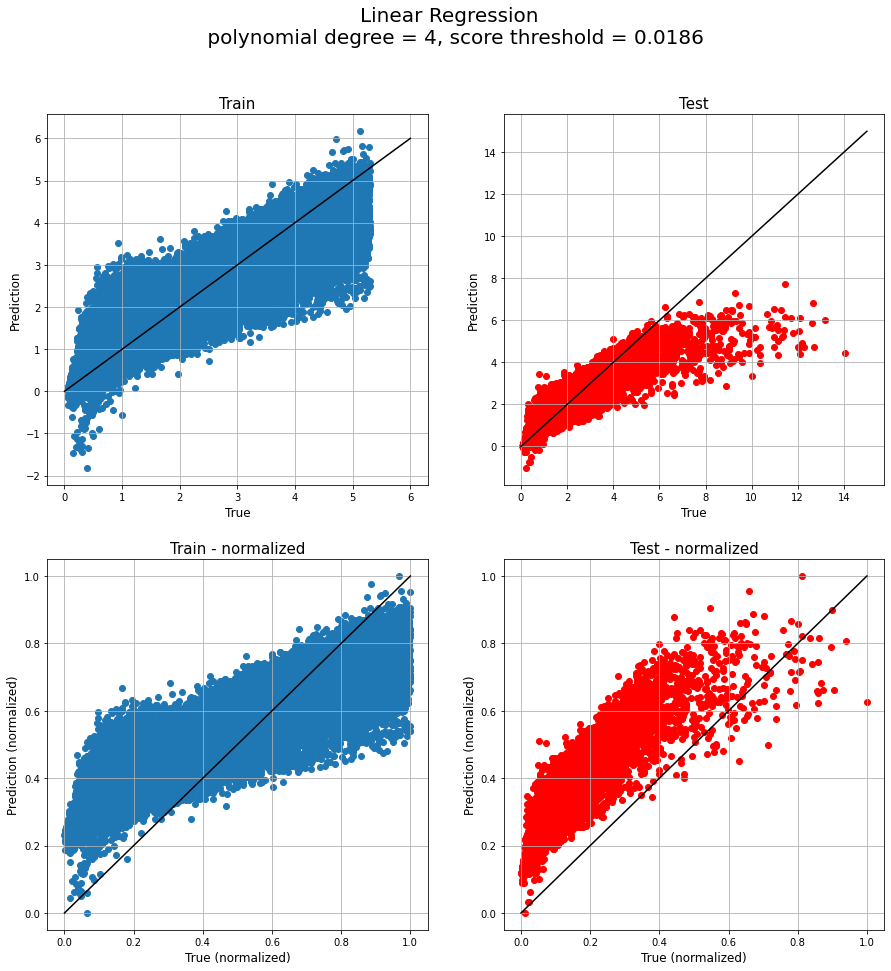


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.33114279705593996
Testing MAE: 0.51557562099689
Training MSE: 0.2370193755895318
Testing MSE: 0.8113837207543118
Training R^2: 0.7845150266236517
Testing R^2: 0.7052583017588281


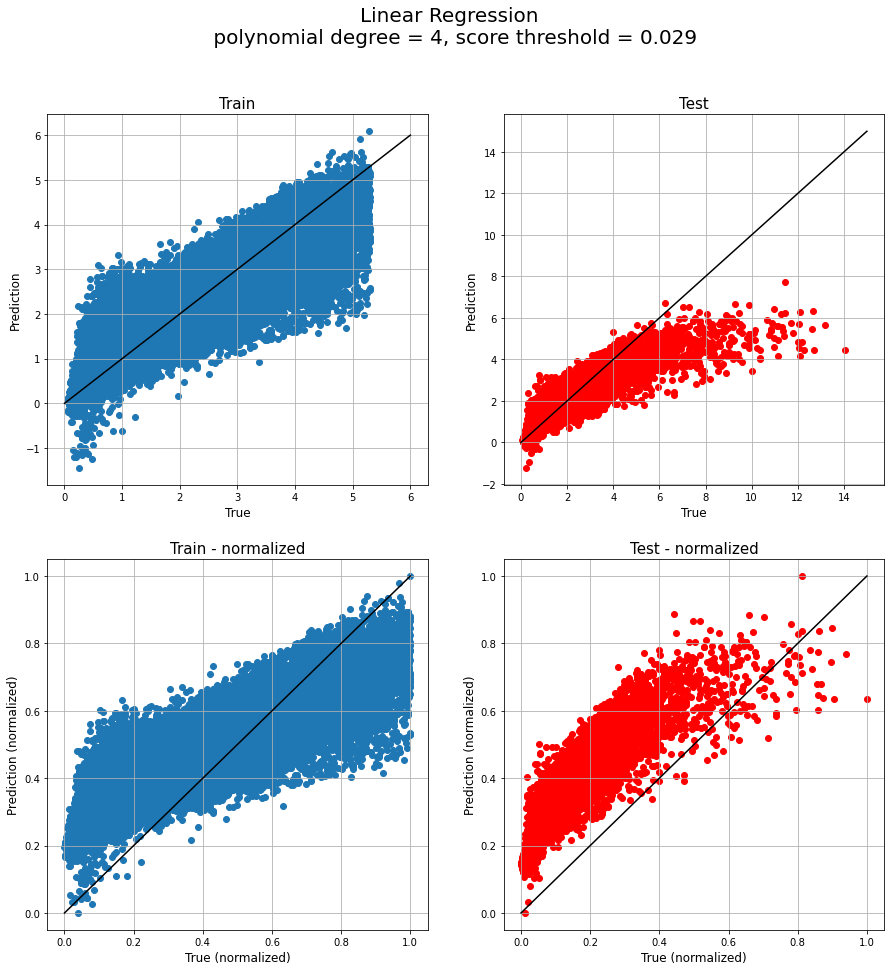


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.33563323983770166
Testing MAE: 0.517321285773335
Training MSE: 0.24252302903799125
Testing MSE: 0.8087309657056299
Training R^2: 0.7795114077681715
Testing R^2: 0.7062219364831475


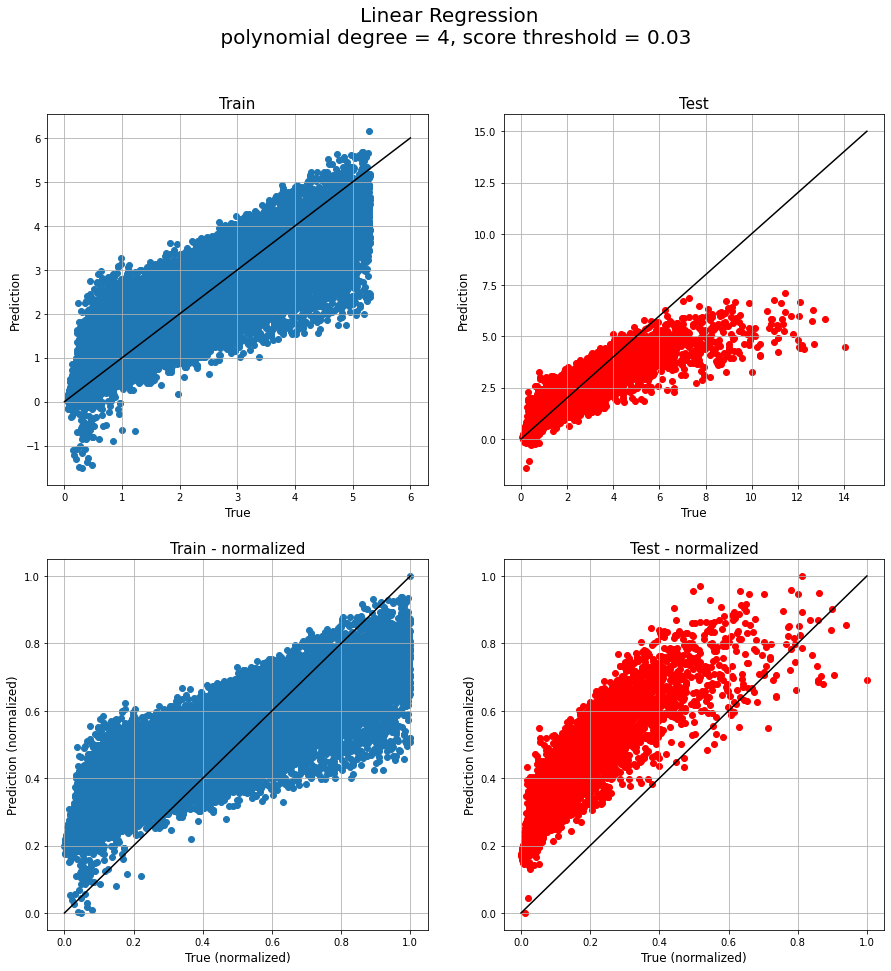


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3567796705402749
Testing MAE: 0.5709180490833331
Training MSE: 0.27709444304614717
Testing MSE: 1.0055315478035016
Training R^2: 0.7480809805779851
Testing R^2: 0.6347325335056604


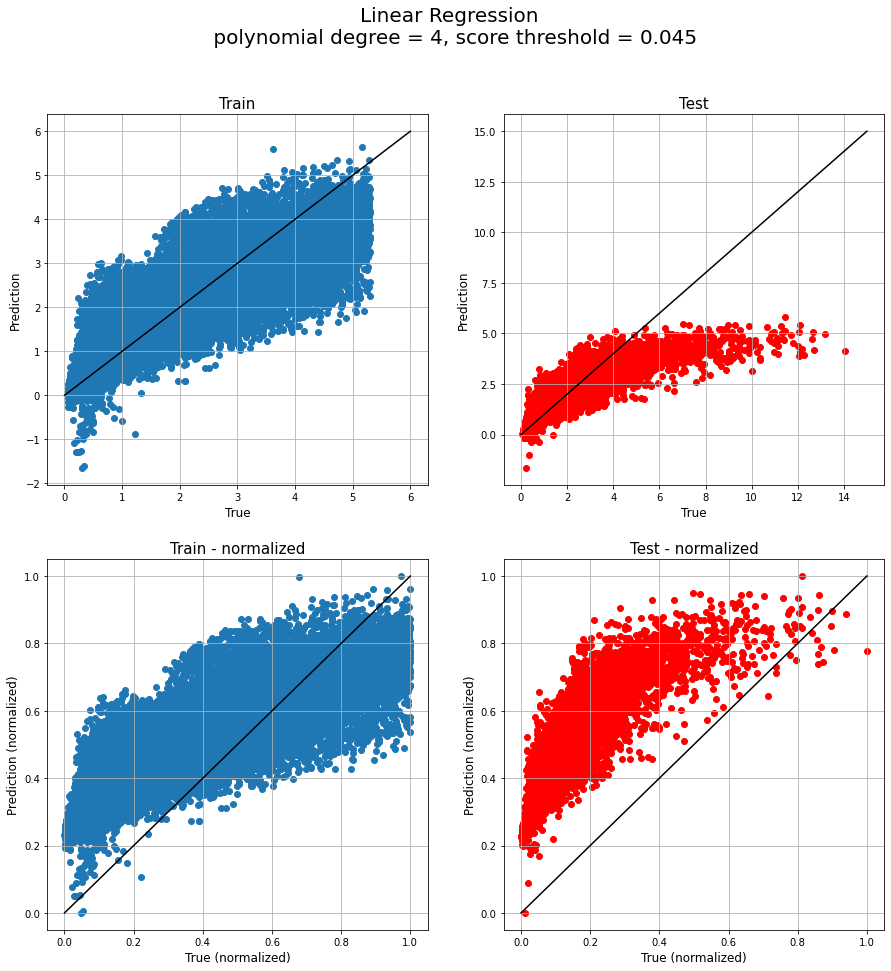


-----------------------


In [18]:
models_4 = dict()

for thr in thresholds:
    name = "thresh_" + str(thr)
    print("Relative feature selection threshold:", thr)
    models_4[name] = modelAuto(df_train, df_test, PolyDegree = 4, select_thresh = thr)
    print("")
    print("-----------------------")

models_evalution["PolyDegree_4"] = models_4

##### 4.1.5 Polynomial degree: 5

<br> For polynomial degrees of higher order, we have chosen not to do a grid search for the best threshold for feature selection, since running time would be too long and it has been proven that the regression has a better performance with all features. </br>
<br> However, this strategy will overflow the memory of the computer, so we are running in next cell a fraction (1/20) of the original training and testing datasets.

In [19]:
# train
# df_train_5 = df_train.copy().sample(frac=1/20, ignore_index=True)
# df_train_5.to_csv("training_set_p5.csv", index=False)
# test
# df_test_5 = df_test.copy().sample(frac=1/20, ignore_index=True)
# df_test_5.to_csv("testing_set_p5.csv", index=False)


Alpha for Lasso regression: 1e-06
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.667e+00, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.0400941950496409
Testing MAE: 0.3242068107431988
Training MSE: 0.003770311493067203
Testing MSE: 0.36338654732986025
Training R^2: 0.9968186833891564
Testing R^2: 0.8753279099028002


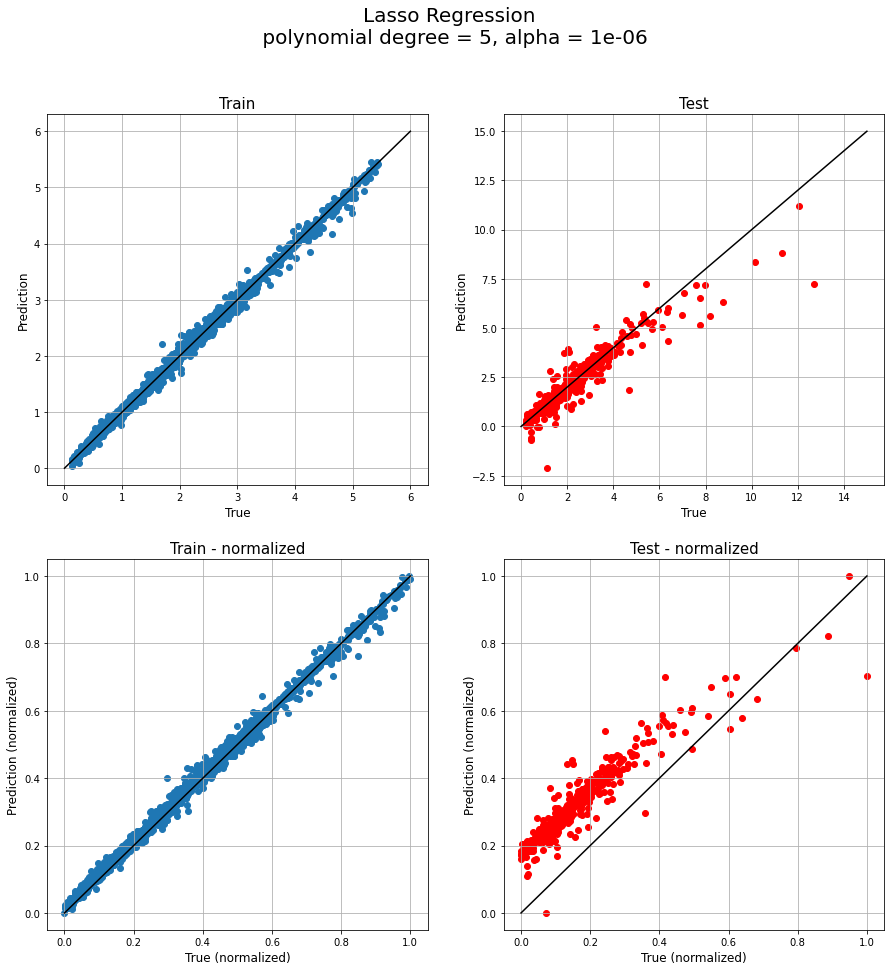


-----------------------
Alpha for Lasso regression: 1e-05
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+01, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.04343768537635731
Testing MAE: 0.3029259541078299
Training MSE: 0.004454283132991107
Testing MSE: 0.32830006415954693
Training R^2: 0.996241561222079
Testing R^2: 0.8873655189533973


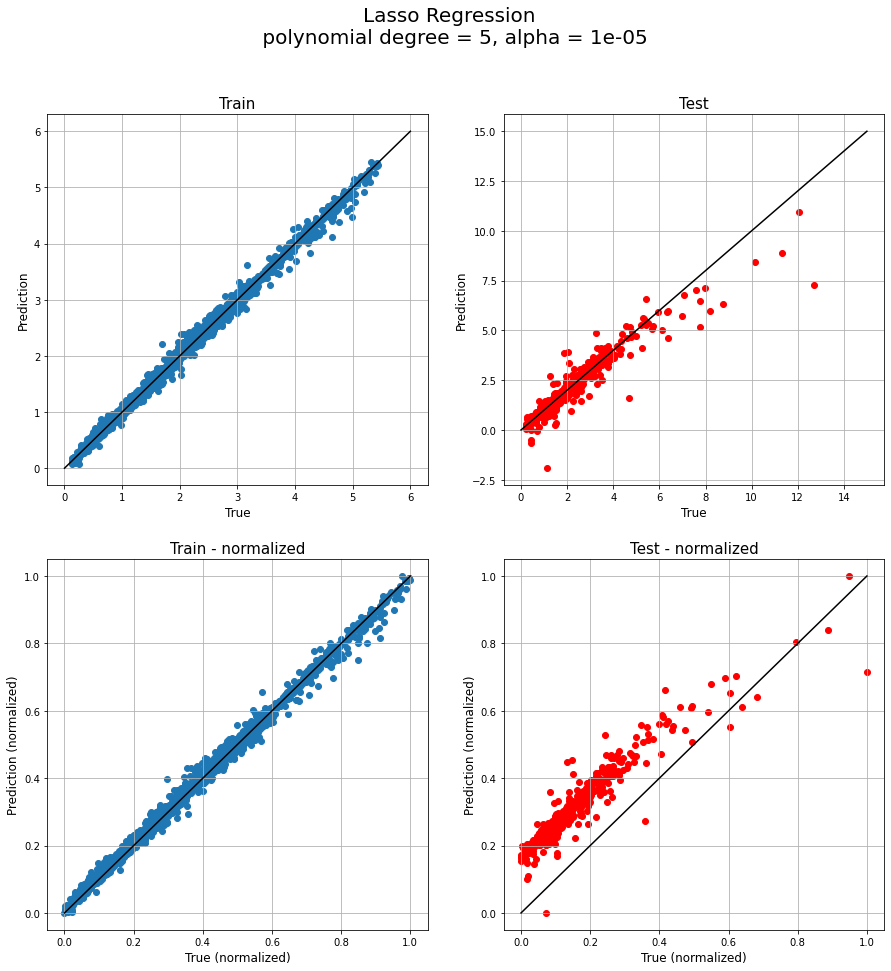


-----------------------
Alpha for Lasso regression: 0.0001
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+01, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.07085200860736847
Testing MAE: 0.24927379040751
Training MSE: 0.012033639094554493
Testing MSE: 0.25458352158074193
Training R^2: 0.9898462458577236
Testing R^2: 0.9126564811686176


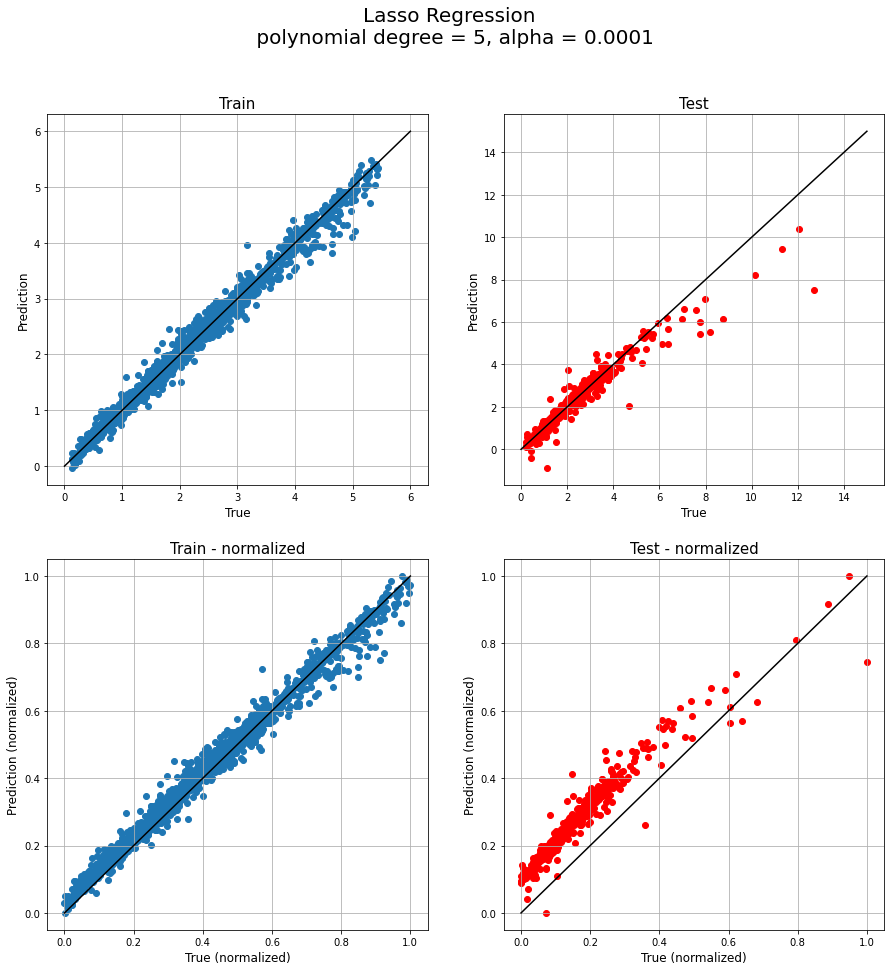


-----------------------
Alpha for Lasso regression: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+01, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.11442636946210197
Testing MAE: 0.2653060331382459
Training MSE: 0.03187834914174326
Testing MSE: 0.2734706656852601
Training R^2: 0.9731016596805381
Testing R^2: 0.9061766052657273


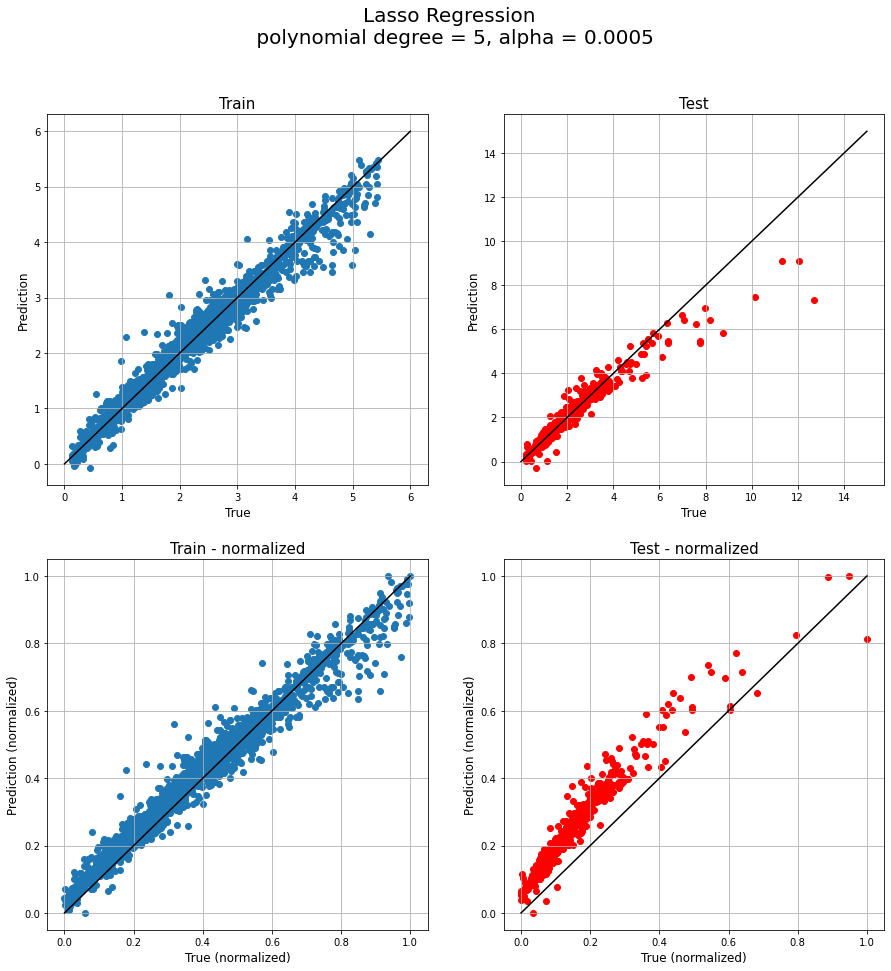


-----------------------
Alpha for Lasso regression: 0.001
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+01, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.14371453202250675
Testing MAE: 0.28586496778624665
Training MSE: 0.04831320630187791
Testing MSE: 0.3272281582542486
Training R^2: 0.9592342420476665
Testing R^2: 0.8877332726597


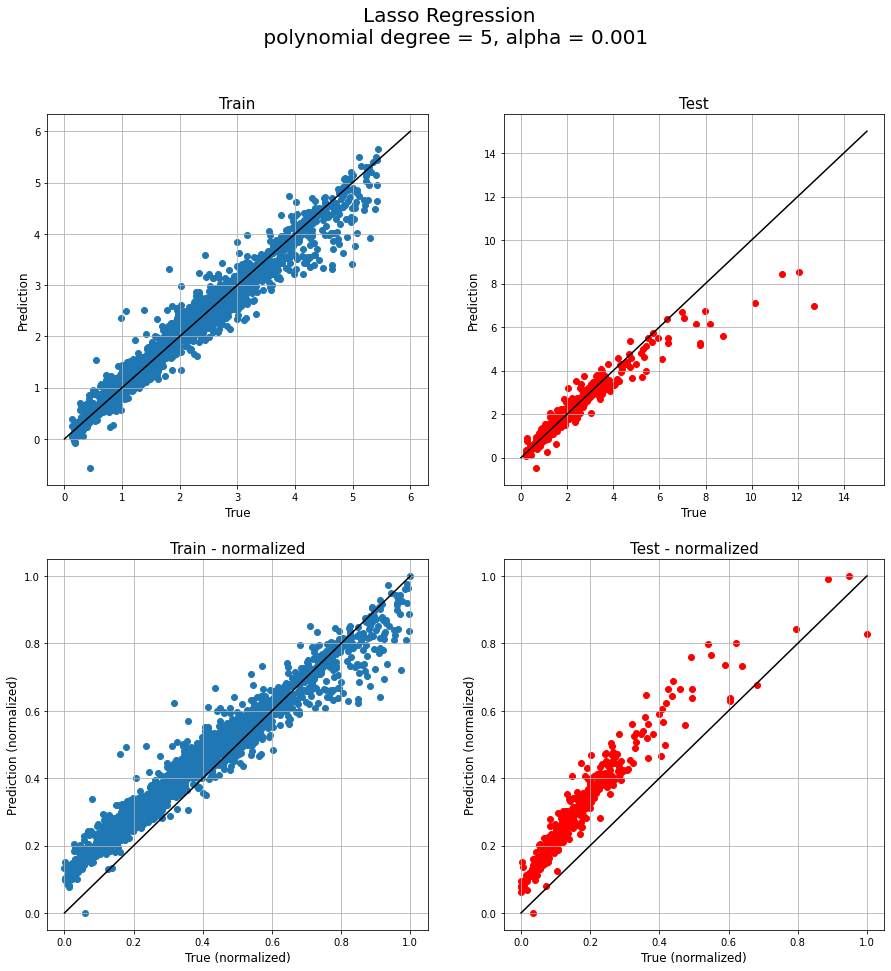


-----------------------
Alpha for Lasso regression: 0.005
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e+00, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.22767267751371154
Testing MAE: 0.35992398232836237
Training MSE: 0.11069921778137778
Testing MSE: 0.4401220472235021
Training R^2: 0.9065941206760088
Testing R^2: 0.8490011919032214


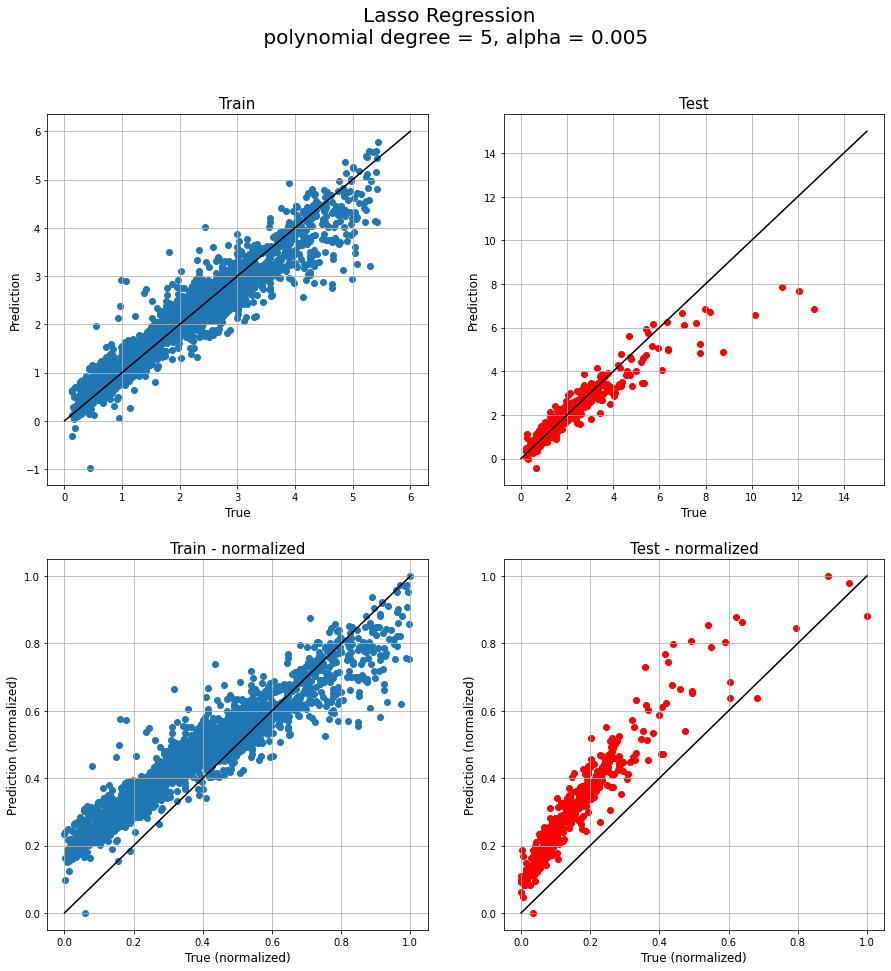


-----------------------
Alpha for Lasso regression: 0.01
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.290e-01, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.27267060913896746
Testing MAE: 0.40323192582289175
Training MSE: 0.14997901377578077
Testing MSE: 0.5307993511318794
Training R^2: 0.8734505812901198
Testing R^2: 0.8178912647864798


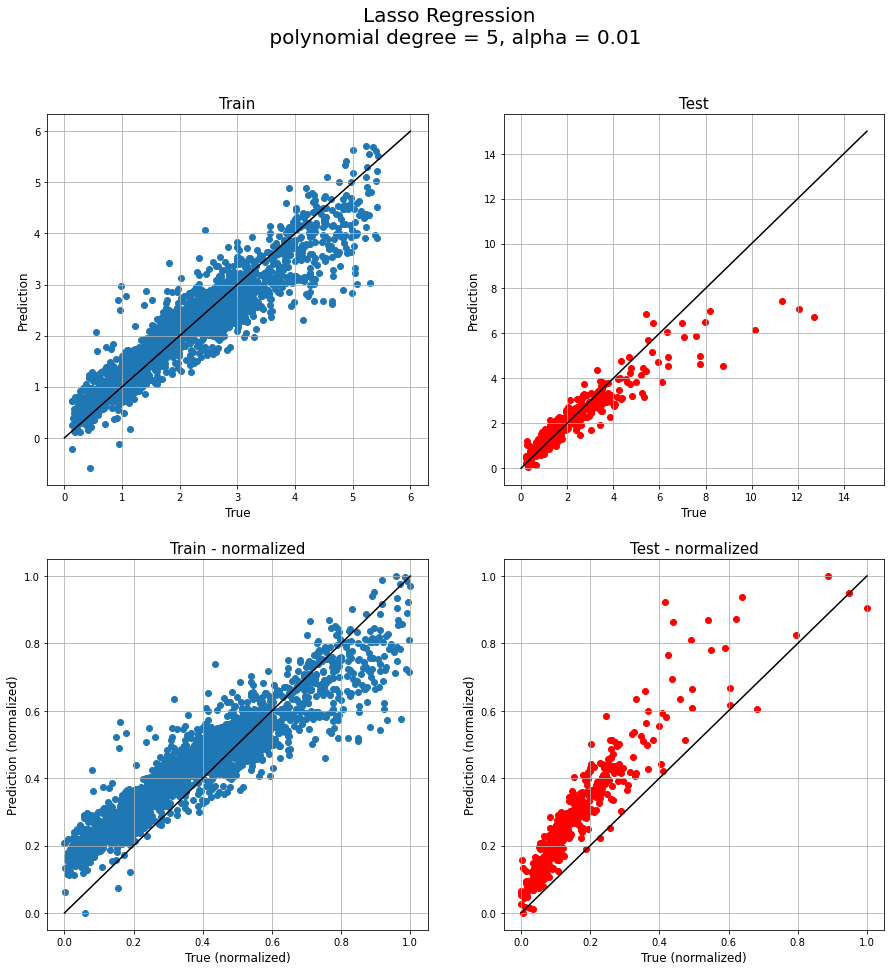


-----------------------
Alpha for Lasso regression: 0.05
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.4452423133983469
Testing MAE: 0.6257937785331079
Training MSE: 0.35995750089215023
Testing MSE: 1.171903108807968
Training R^2: 0.6962747563718225
Testing R^2: 0.5979388586615134


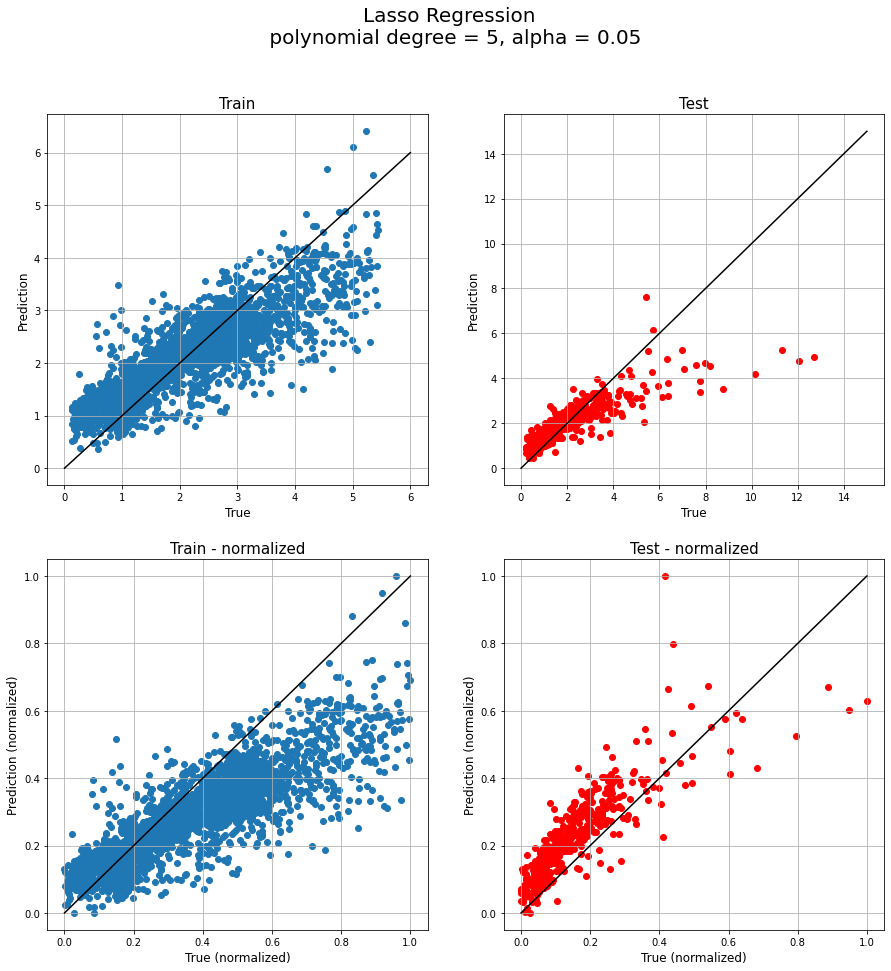


-----------------------
Alpha for Lasso regression: 0.1
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.523685369777398
Testing MAE: 0.7284571428689348
Training MSE: 0.485719082282232
Testing MSE: 1.5038466555260719
Training R^2: 0.5901595431811075
Testing R^2: 0.48405435724639223


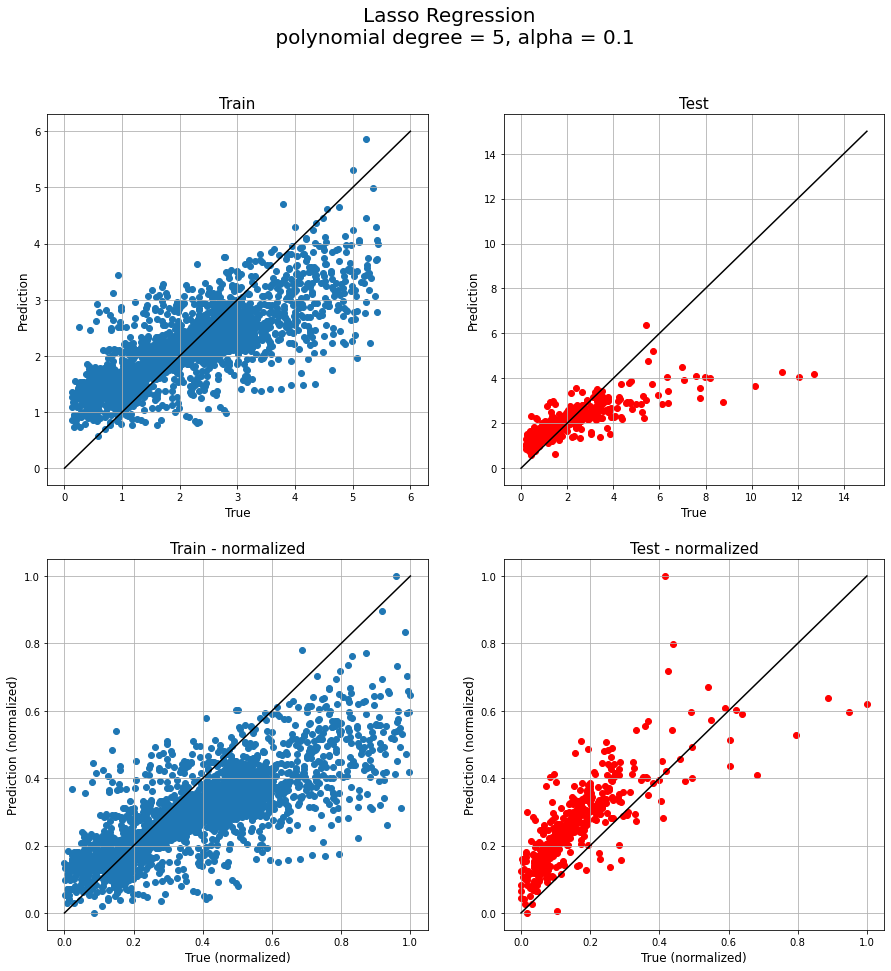


-----------------------


In [26]:
# train
df_train_5 = pd.read_csv("training_set_p5.csv")
# test
df_test_5 = pd.read_csv("testing_set_p5.csv")

models_5 = dict()

for a in alpha:
    name = "alpha_" + str(a)
    print("Alpha for Lasso regression:", a)
    models_5[name] = modelAuto(df_train_5, df_test_5, PolyDegree = 5, select_thresh = 0, alpha = a)
    print("")
    print("-----------------------")

models_evalution["PolyDegree_5"] = models_5

##### 4.1.6 Polynomial degree: 6

<br> For polynomial degrees of higher order, we have chosen not to do a grid search for the best threshold for feature selection, since running time would be too long and it has been proven that the regression has a better performance with all features. </br>
<br> However, this strategy will overflow the memory of the computer, so we are running in next cell a fraction (1/30) of the original training and testing datasets.

In [21]:
# train
# df_train_6 = df_train.copy().sample(frac=1/30, ignore_index=True)
# df_train_6.to_csv("training_set_p6.csv", index = False)
# test
# df_test_6 = df_test.copy().sample(frac=1/30, ignore_index=True)
# df_test_6.to_csv("testing_set_p6.csv", index = False)


Alpha for Lasso regression: 1e-06
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+00, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.008743022841775836
Testing MAE: 0.5715808190766778
Training MSE: 0.00037465797975894935
Testing MSE: 1.223589913022512
Training R^2: 0.9996673157427867
Testing R^2: 0.6400087368721907


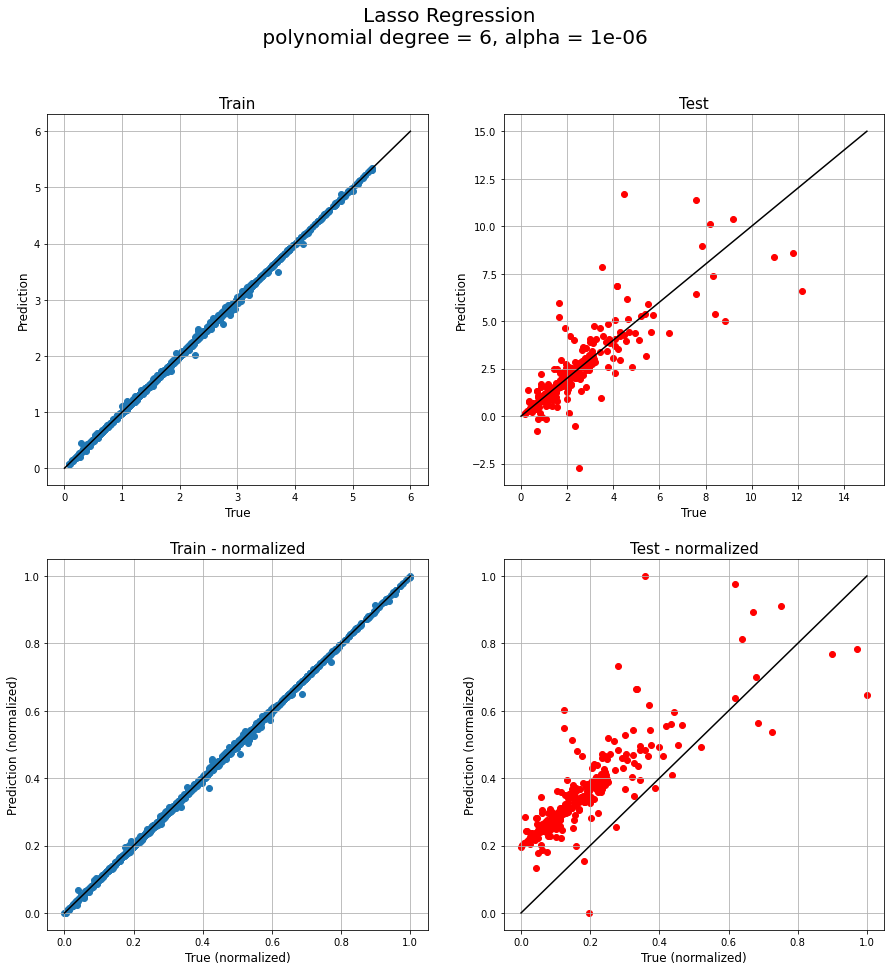


-----------------------
Alpha for Lasso regression: 1e-05
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.469e+00, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.015291344709038828
Testing MAE: 0.4755312330198619
Training MSE: 0.0008391114275734477
Testing MSE: 0.8757217481831338
Training R^2: 0.9992548959929238
Testing R^2: 0.7423547097587593


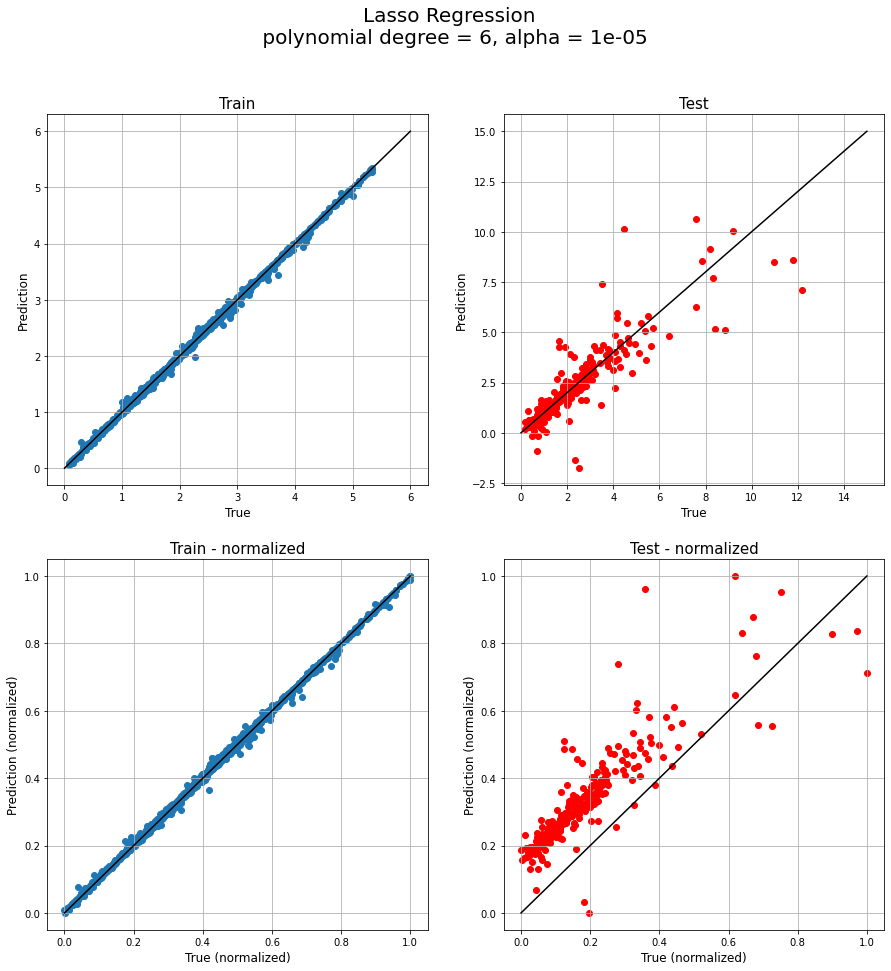


-----------------------
Alpha for Lasso regression: 0.0001
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+01, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.043383998796097986
Testing MAE: 0.3396304730467362
Training MSE: 0.005047711428991473
Testing MSE: 0.4903818721149849
Training R^2: 0.9955177943134653
Testing R^2: 0.8557252003479001


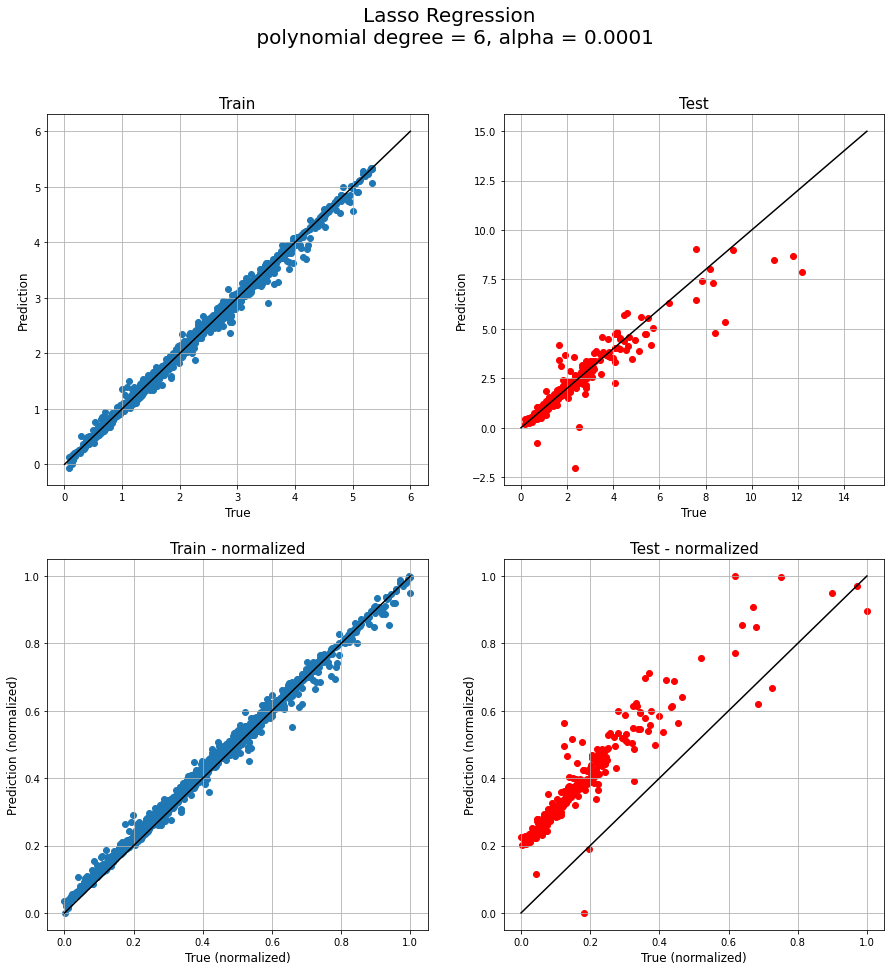


-----------------------
Alpha for Lasso regression: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.759e+00, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.08655026460669399
Testing MAE: 0.317310303577736
Training MSE: 0.018125444228951817
Testing MSE: 0.4190173573950655
Training R^2: 0.9839051874623094
Testing R^2: 0.8767212885986327


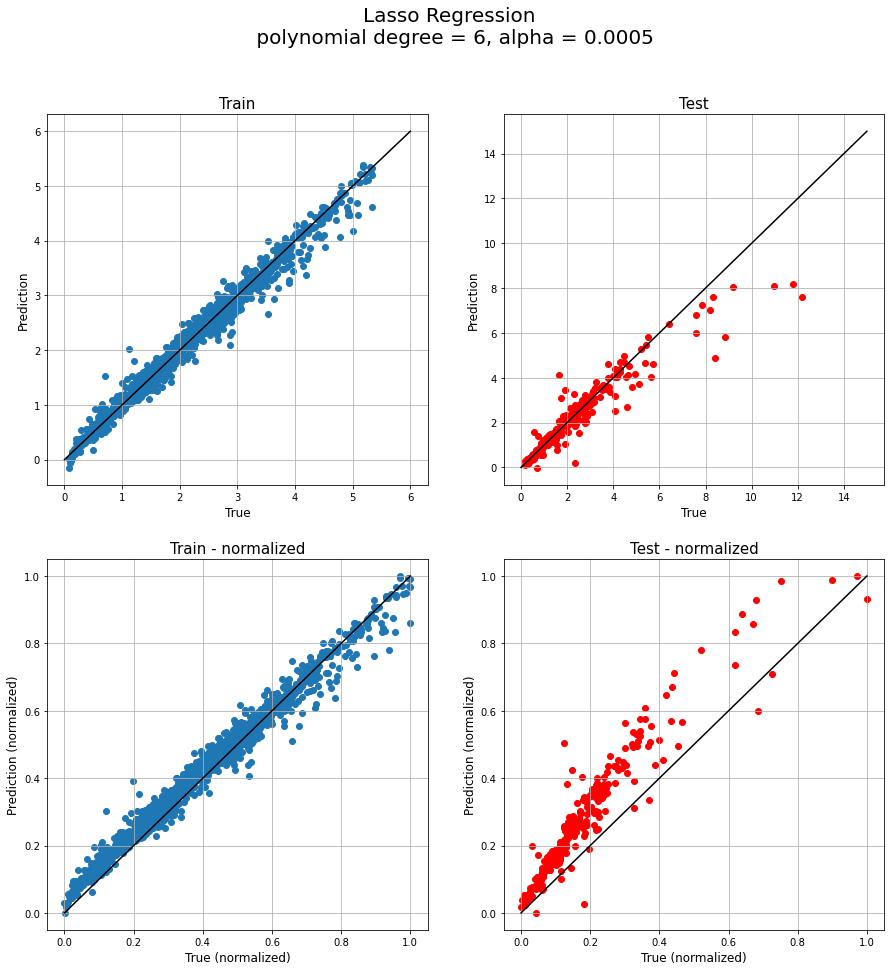


-----------------------
Alpha for Lasso regression: 0.001
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+01, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.11188062650370877
Testing MAE: 0.34273404941193414
Training MSE: 0.029426534771751837
Testing MSE: 0.48068376104672983
Training R^2: 0.9738701818944292
Testing R^2: 0.8585784726871521


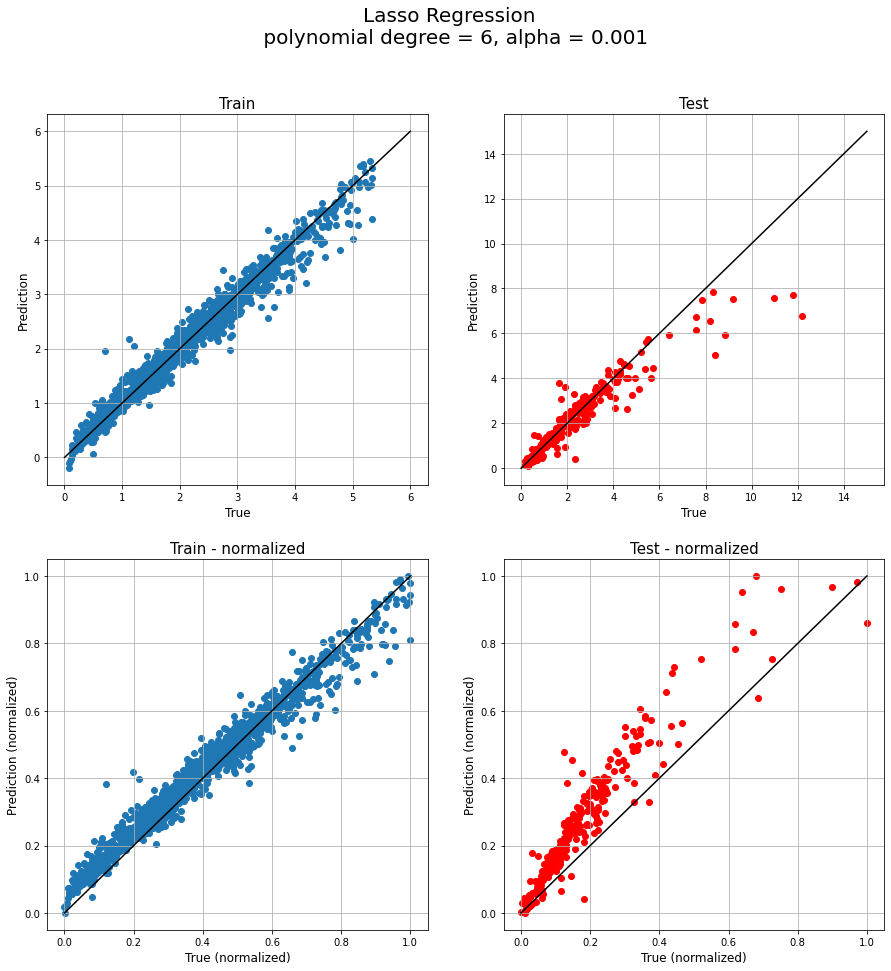


-----------------------
Alpha for Lasso regression: 0.005
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e+00, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.2014514963433776
Testing MAE: 0.4228649049778042
Training MSE: 0.08574084008146352
Testing MSE: 0.7510178326008123
Training R^2: 0.9238648868130354
Testing R^2: 0.7790437340876462


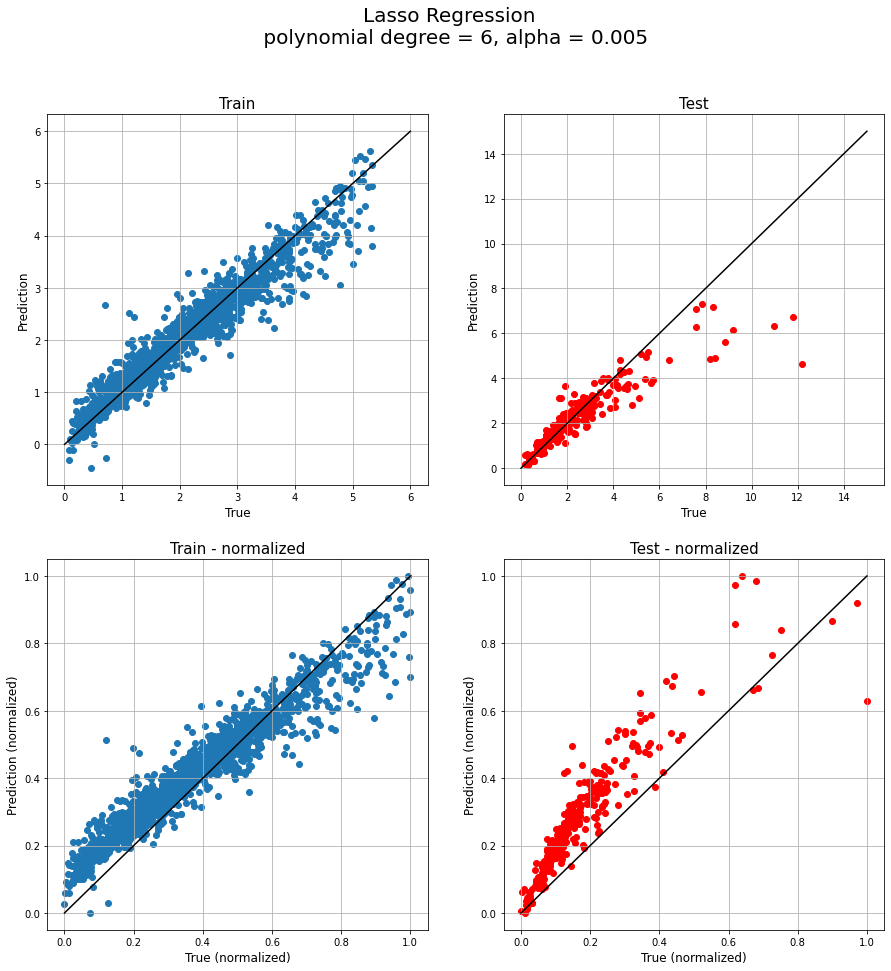


-----------------------
Alpha for Lasso regression: 0.01
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e-01, tolerance: 2.143e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.2533455578619836
Testing MAE: 0.4737515876662239
Training MSE: 0.12853493450391731
Testing MSE: 0.9118170445758723
Training R^2: 0.8858651049180646
Testing R^2: 0.7317351457993795


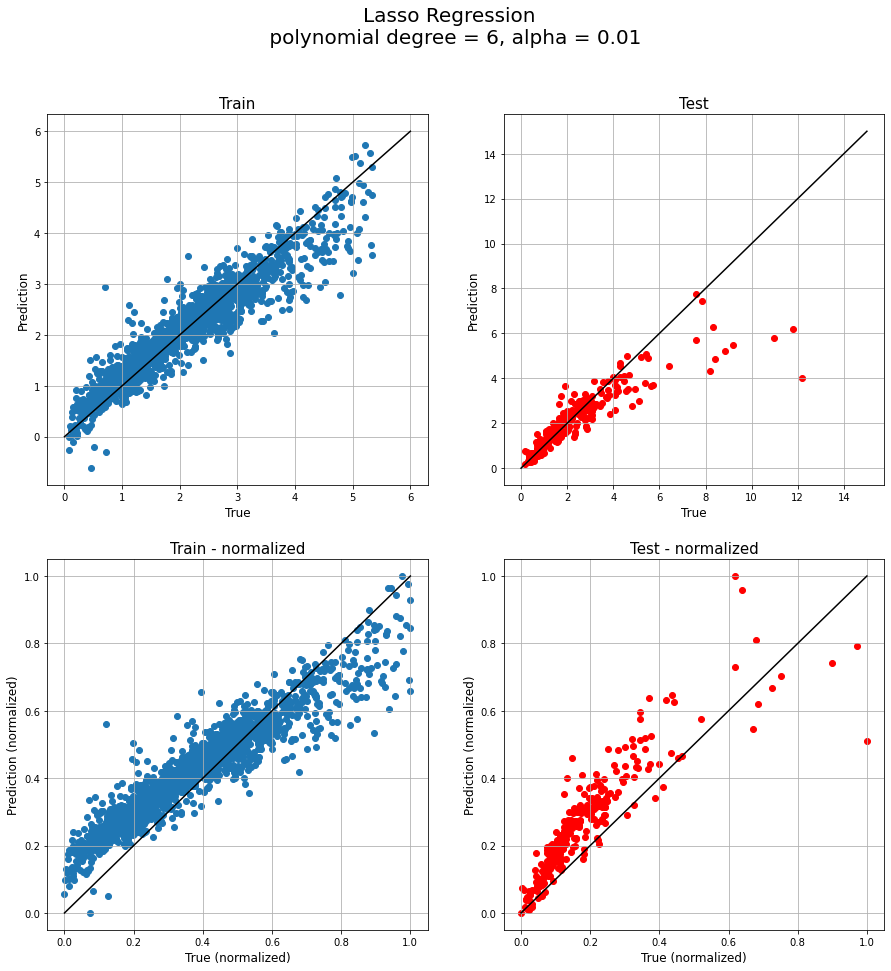


-----------------------
Alpha for Lasso regression: 0.05
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.4216807785948044
Testing MAE: 0.6936105065114054
Training MSE: 0.32067930283433044
Testing MSE: 1.5556791059872488
Training R^2: 0.715247074850075
Testing R^2: 0.5423050807909144


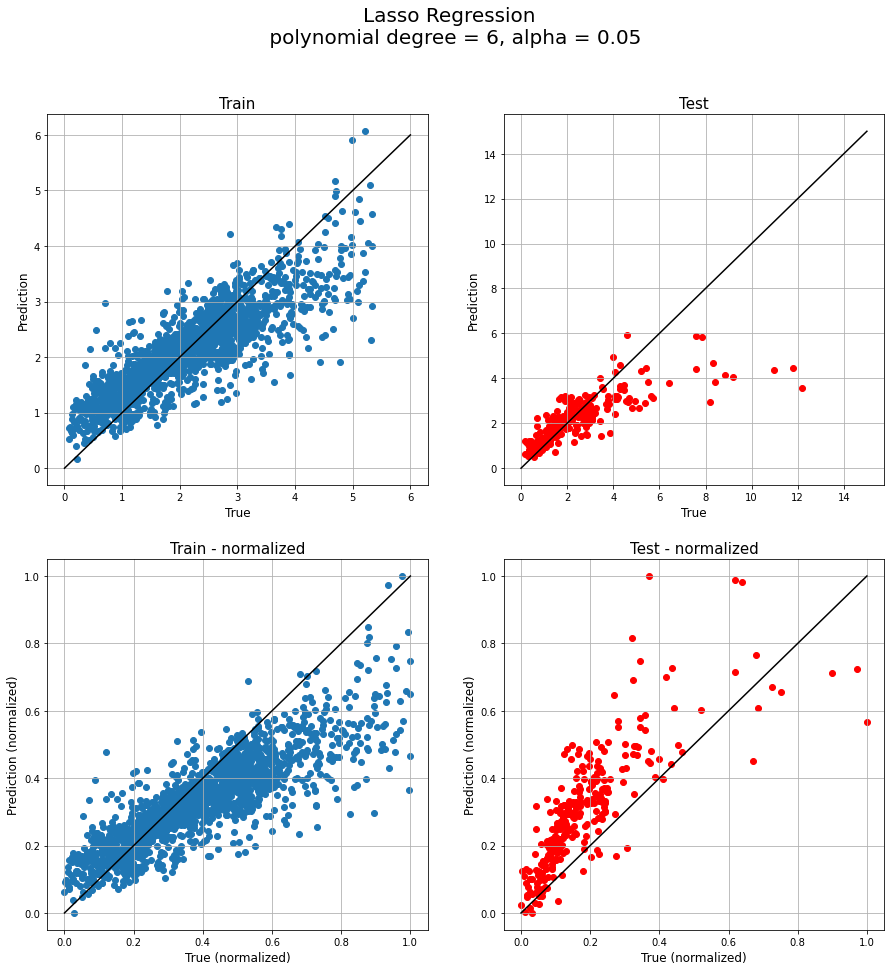


-----------------------
Alpha for Lasso regression: 0.1
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.4999368473119558
Testing MAE: 0.7900873720854917
Training MSE: 0.4417856802716479
Testing MSE: 1.8815397900352475
Training R^2: 0.6077084999411639
Testing R^2: 0.4464339085904513


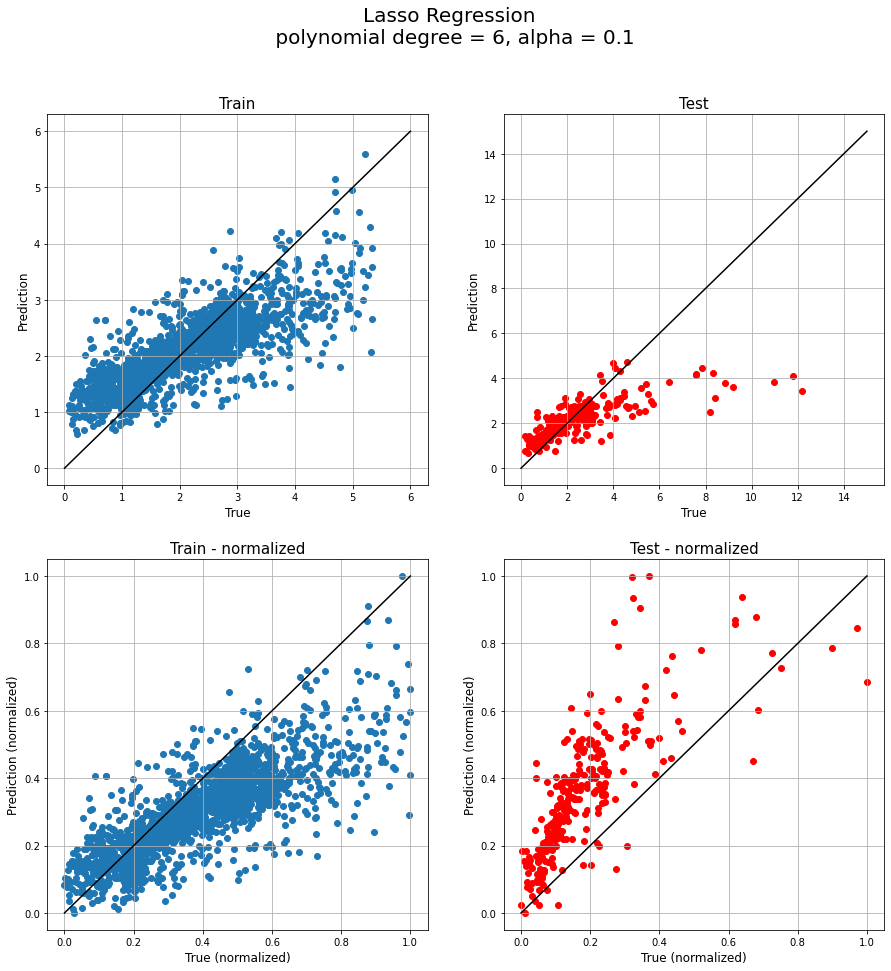


-----------------------


In [22]:
# train
df_train_6 = pd.read_csv("training_set_p6.csv")
# test
df_test_6 = pd.read_csv("testing_set_p6.csv")

models_6 = dict()

for a in alpha:
    name = "alpha_" + str(a)
    print("Alpha for Lasso regression:", a)
    models_6[name] = modelAuto(df_train_6, df_test_6, PolyDegree = 6, select_thresh = 0, alpha = a)
    print("")
    print("-----------------------")

models_evalution["PolyDegree_6"] = models_6

##### 4.1.7 Polynomial degree 5, with cross validation grid search

Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.769e+00, tolerance: 2.760e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.797e+00, tolerance: 2.681e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Training MAE: 0.11442636946210197
Testing MAE: 0.2653060331382459
Training MSE: 0.03187834914174326
Testing MSE: 0.2734706656852601
Training R^2: 0.9731016596805381
Testing R^2: 0.9061766052657273


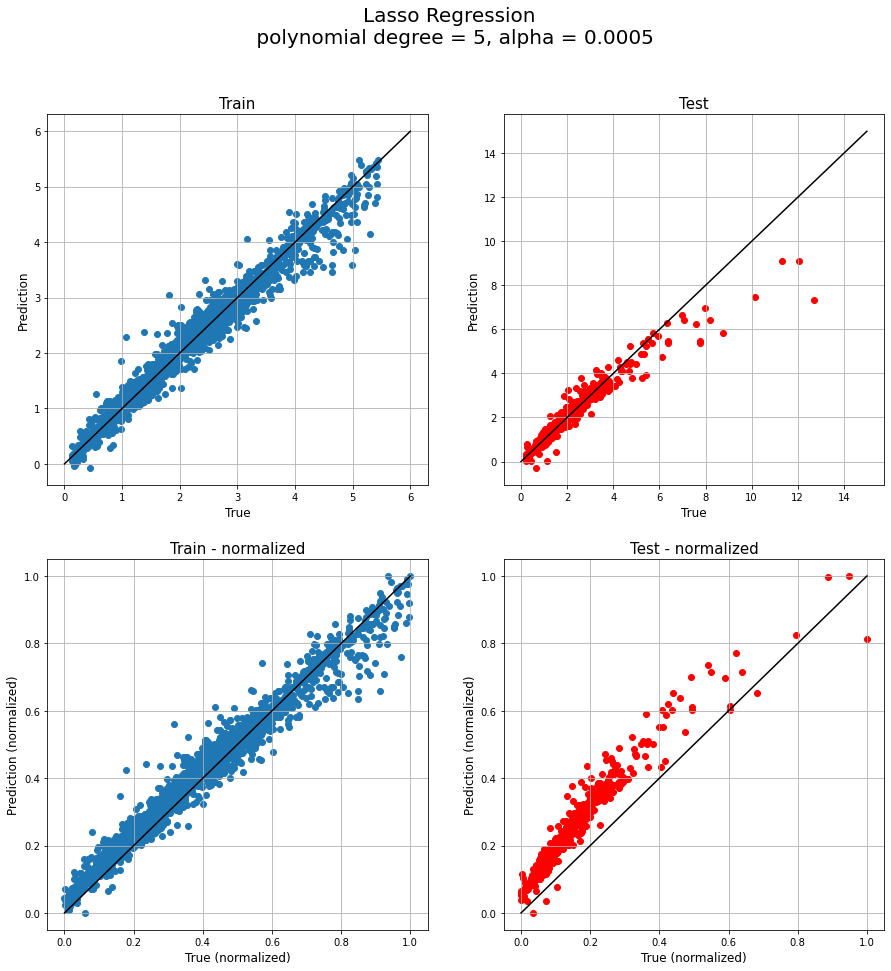

In [29]:
# train
df_train_5 = pd.read_csv("training_set_p5.csv")
# test
df_test_5 = pd.read_csv("testing_set_p5.csv")

model_CV5 = modelAuto(df_train = df_train_5, df_test = df_test_5, 
                      PolyDegree = 5, select_thresh = 0, cv = True)

models_evalution["PolyDegree_5"]["cv5"] = model_CV5

##### 4.1.8 Polynomial degree 6, with cross validation grid search

Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.974e-01, tolerance: 1.694e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.200e-01, tolerance: 1.710e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Training MAE: 0.11188062650370877
Testing MAE: 0.34273404941193414
Training MSE: 0.029426534771751837
Testing MSE: 0.48068376104672983
Training R^2: 0.9738701818944292
Testing R^2: 0.8585784726871521


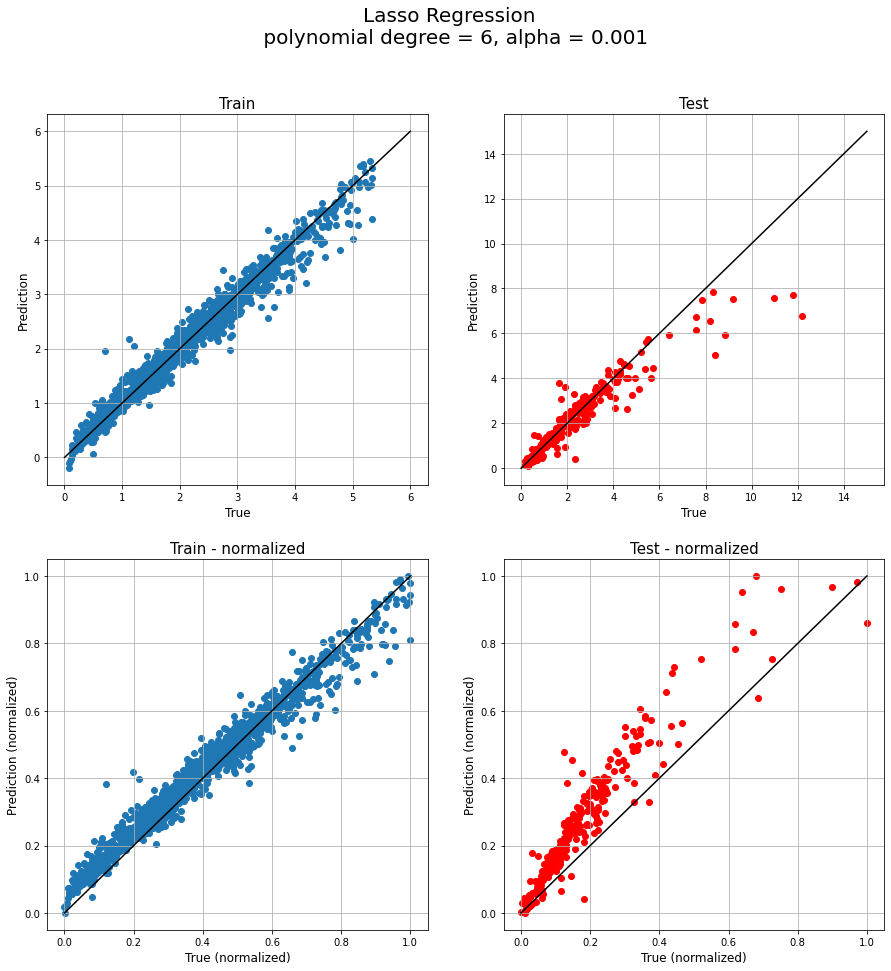

In [25]:
# train
df_train_6 = pd.read_csv("training_set_p6.csv")
# test
df_test_6 = pd.read_csv("testing_set_p6.csv")

model_CV6 = modelAuto(df_train = df_train_6, df_test = df_test_6, 
                      PolyDegree = 6, select_thresh = 0, cv = True)

models_evalution["PolyDegree_6"]["cv6"] = model_CV6